# DATAIKU TEST ALEXANDRE MONLOUIS

# Introduction 


The dataset contains about 300 000 rows and contains data about individuals , education work, family , race etc from the US Census bureau.
The goal is to predict whether an individual earns more than 50K dollars a year or not, and to give clear insights about the profiles of high income earners and visualise the data.
The dataset has about 6% individuals who earn more than 50K, thus making the dataset very unbalanced.
This project shows how to classify data with numerical and categorical data, on an unbalanced dataset ( 6 % of positives).
An important aspect is to have a good recall, as identifying most of the individuals with more than 50k earnings is important, but also a good precision, because we do not want to have too many false positives.
Thus, the ROC curves and setting threshold values for the classifier is an important aspect of the problem, and we will choose the f1 score as our performance metric.

The choice of the classifier will be logistic regression, a simple supervised algorithm, and Random Forest, a tree based algorithm. Both models estimate probabilities which will be helpful to set thresholds.

We do a 3 fold cross validation to see the performance of our models.However we are choosing the f1 score as the metric because we have an unabalanced dataset with few positive observations.

The plots of correlation and scatterplots are used to choose which variables we will be keeping, and variables whith a high amount of NUlls are discarded or replaced . Categorical variables are transformed into dummy variables in order to be used by the model.

We choose the parameters for our model using GridSearchCV, from scikit learn.


We import the needed python modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import decomposition
from sklearn import model_selection
import graphviz 
from sklearn import tree
import os 
import matplotlib.image as mpimg

Here we will start naming the columns according to the metadata file, and having a quick look at our data.

In [2]:
df= pd.read_csv('census_income_learn.csv')
df_test=pd.read_csv('census_income_test.csv')

columns=['AAGE','ACLSWKR','ADTIND','ADTOCC','AHGA','AHRSPAY','AHSCOL','AMARITL','AMJIND','AMJOCC','ARACE','AREORGN','ASEX','AUNMEM','AUNTYPE'\
         ,'AWKSTAT','CAPGAIN','CAPLOSS','DIVVAL','FILESTAT','GRINREG','GRINST','HHDFMX','HHDREL','MARSUPWT','MIGMTR1',\
         'MIGMTR3','MIGMTR4','MIGSAME','MIGSUN','NOEMP','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY','PRCITSHP','SEOTR','VETQVA','VETYN','WKSWORK','YEAR','INCOME']
df.columns=columns
df_test.columns=columns

numerical=['AAGE','AHRSPAY','CAPGAIN','CAPLOSS','DIVVAL','NOEMP','WKSWORK','INCOME']
categorical=['ACLSWKR','ADTIND','ADTOCC','AHGA','AHSCOL','AMARITL','AMJIND','AMJOCC','ARACE','AREORGN','ASEX','AUNMEM',\
             'AUNTYPE','AWKSTAT','FILESTAT','GRINREG','GRINST','HHDFMX','HHDREL','MIGMTR1','MIGMTR3',\
             'MIGMTR4','MIGSAME','MIGSUN','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY','PRCITSHP','SEOTR','VETQVA','VETYN','YEAR','INCOME']
weights_train=df['MARSUPWT']
weights_test=df_test['MARSUPWT']

y_train=pd.get_dummies(df['INCOME'])
y_train.drop(columns=' - 50000.',inplace=True) #this column is now redundant
y_train=np.ravel(y_train)
df["INCOME"]=y_train

y_test=pd.get_dummies(df_test['INCOME'])
y_test.drop(columns=' - 50000.',inplace=True) #this column is now redundant
df_test["INCOME"]=y_test
y_test=np.ravel(y_test)

df.drop(columns=['MARSUPWT'],inplace=True)
df_test.drop(columns=['INCOME','MARSUPWT'],inplace=True)

df[categorical]=df[categorical].astype(object)
df_test[categorical]=df[categorical].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199522 entries, 0 to 199521
Data columns (total 41 columns):
AAGE        199522 non-null int64
ACLSWKR     199522 non-null object
ADTIND      199522 non-null object
ADTOCC      199522 non-null object
AHGA        199522 non-null object
AHRSPAY     199522 non-null int64
AHSCOL      199522 non-null object
AMARITL     199522 non-null object
AMJIND      199522 non-null object
AMJOCC      199522 non-null object
ARACE       199522 non-null object
AREORGN     199522 non-null object
ASEX        199522 non-null object
AUNMEM      199522 non-null object
AUNTYPE     199522 non-null object
AWKSTAT     199522 non-null object
CAPGAIN     199522 non-null int64
CAPLOSS     199522 non-null int64
DIVVAL      199522 non-null int64
FILESTAT    199522 non-null object
GRINREG     199522 non-null object
GRINST      199522 non-null object
HHDFMX      199522 non-null object
HHDREL      199522 non-null object
MIGMTR1     199522 non-null object
MIGMTR3     199522 

In [3]:
df.head(6)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,INCOME
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,0
5,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0


In [4]:
df.describe()

,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK
count,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000
mean,34.494006,55.427186,434.721169,37.313975,197.530523,1.956190,23.175013
std,22.310785,274.897115,4697.542951,271.897097,1984.168581,2.365127,24.411494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000


In [5]:
low_income_numerical=df[numerical].groupby('INCOME').get_group(0)
high_income_numerical=df[numerical].groupby('INCOME').get_group(1)

In [6]:
print("%f is the ratio of high income earners compared to the low income learners."%(1-len(high_income_numerical)/len(low_income_numerical)))

0.933836 is the ratio of high income earners compared to the low income learners.


The dataset is highly unbalanced, and we will have to care for AUC to see the performance of the classifier we will produce. A naive classifier that classifies avery data point as the most frequent class will have an acuracy close to 0.93 !

We can observe that our entire dataset does not have null values. However, the surveys with unanswered questions have been encoded with "NA" (No answer)


We have a look at the distribution of our data for each of our continuous variables:



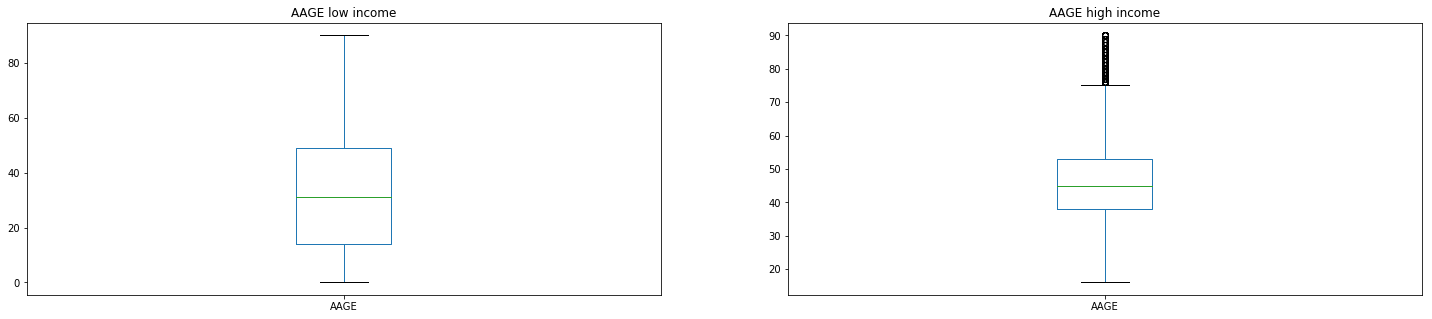

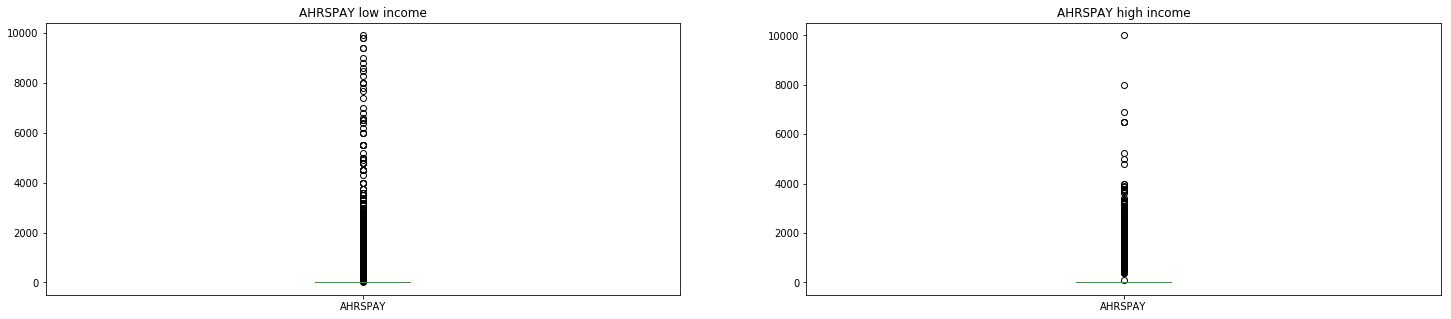

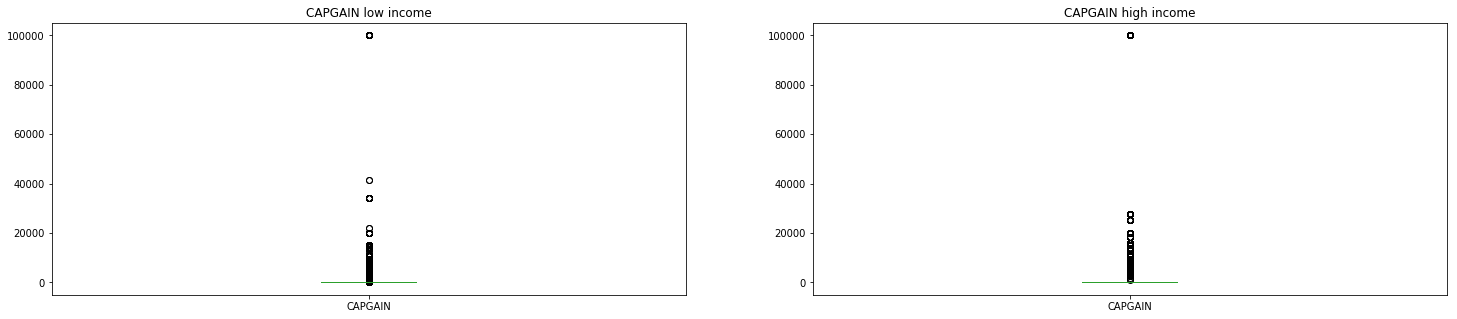

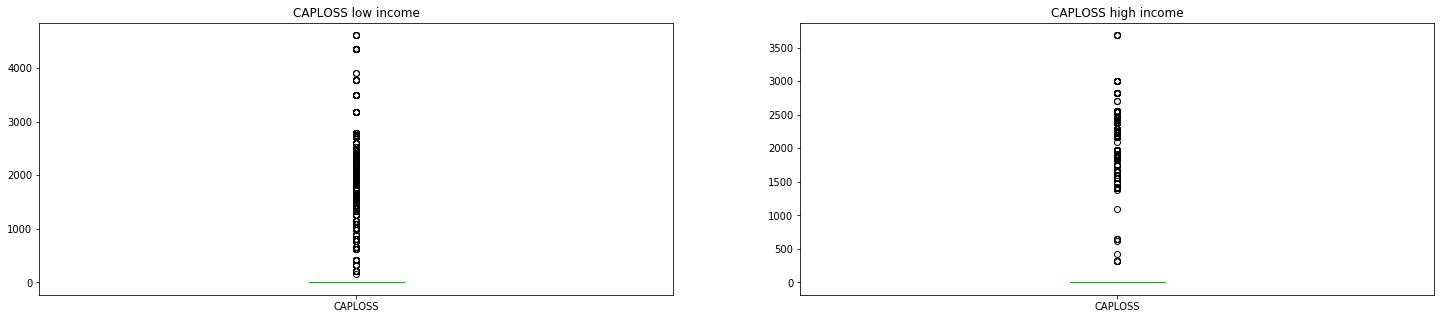

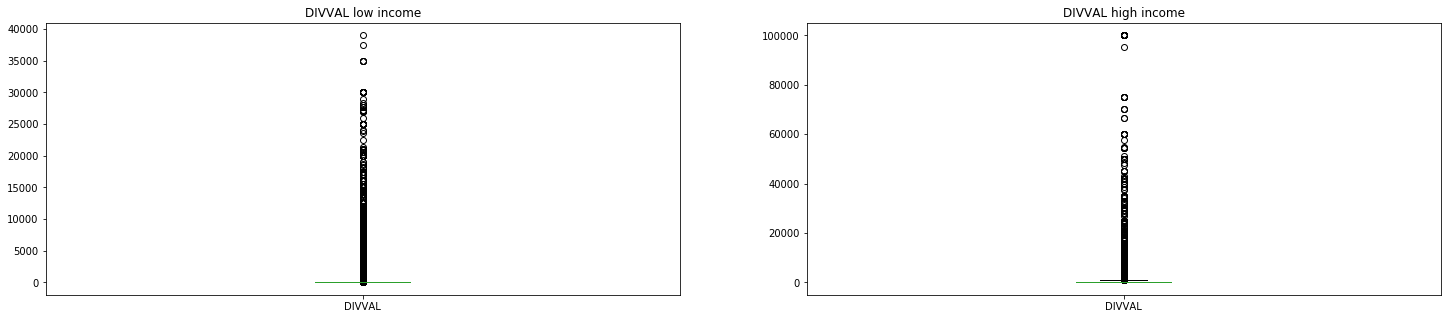

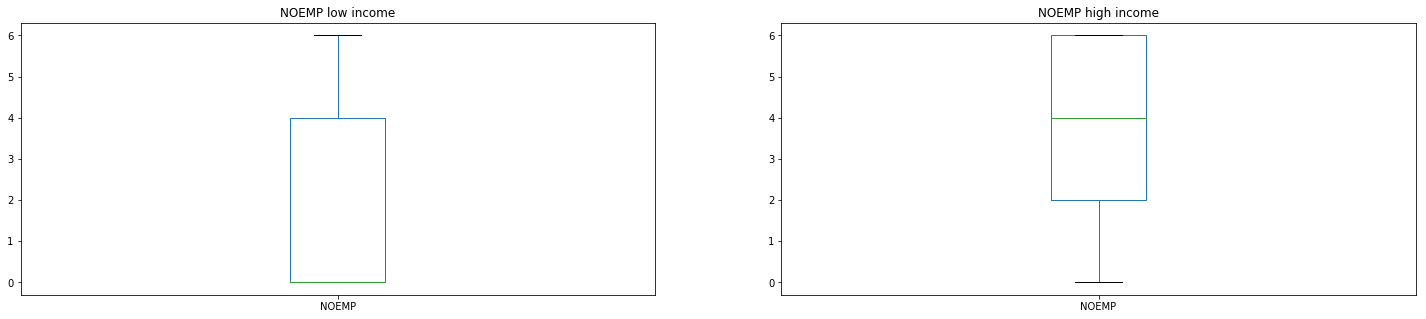

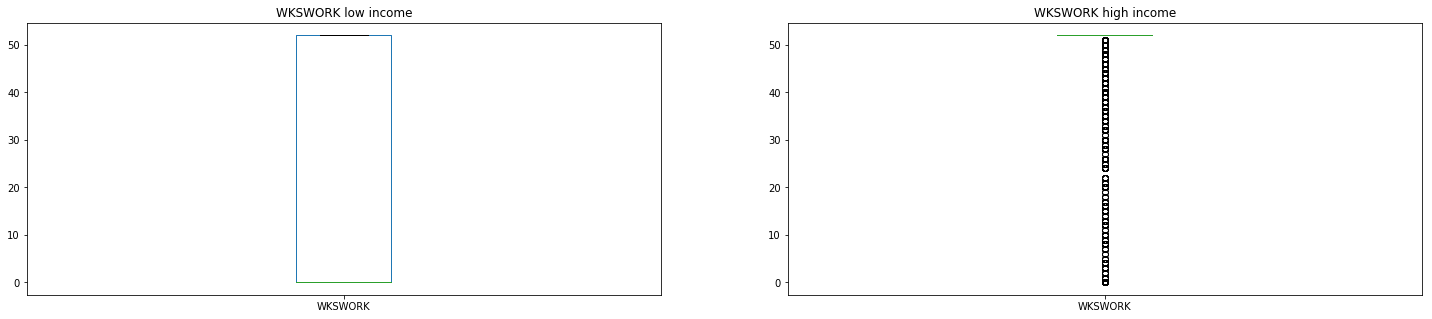

In [7]:
for k in numerical[:-1]:
    fig,axes=plt.subplots(nrows=1,ncols=2)
    df[k].loc[(df["INCOME"]==1) ].plot(kind="box",title=(k+' high income'),ax=axes[1],figsize=(25,5))
    df[k].loc[(df["INCOME"]==0) ].plot(kind="box",title=(k+' low income'),ax=axes[0],figsize=(25,5))
    plt.show()

Text(0.5,0.98,'Low income')

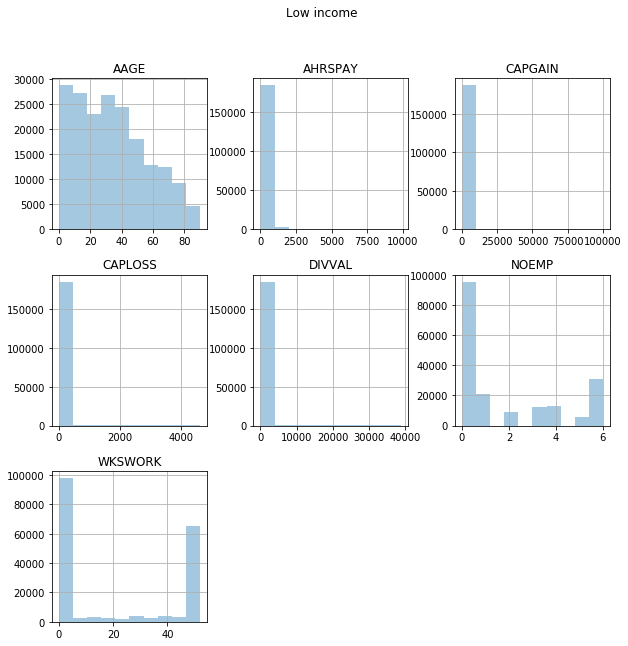

In [8]:
low_income_numerical.groupby('INCOME').hist(alpha=0.4,figsize=(10,10)) #_plot of the histograms of the numerical variable
plt.suptitle('Low income')

Text(0.5,0.98,'High income')

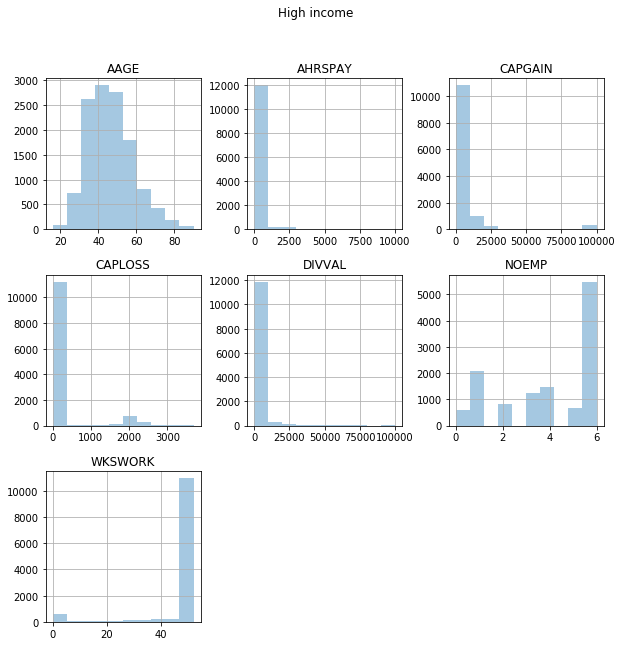

In [9]:
high_income_numerical.groupby('INCOME').hist(alpha=0.4,figsize=(10,10)) #_plot of the histograms of the numerical variable
plt.suptitle('High income')

These boxplots of the numerical data show that the median age of low income earners is 30 years old, compared to 45 years old for the higher income earners. This is logic because they had time to finish their studies and start earning money. Capital income and dividends are often not present/reported throughout the dataset, because most people earn money through their wage only.Finally, compared to low incomes, high income earners typically work more than 50 weeks a year, and have worked for several employers (2-6) before.

We can already see that most values for capital and hourly wage are set to zero, and that high income earners are apparently older than lower income earners.
We will now plot a scatter matrix to see relationships between our numerical variables.

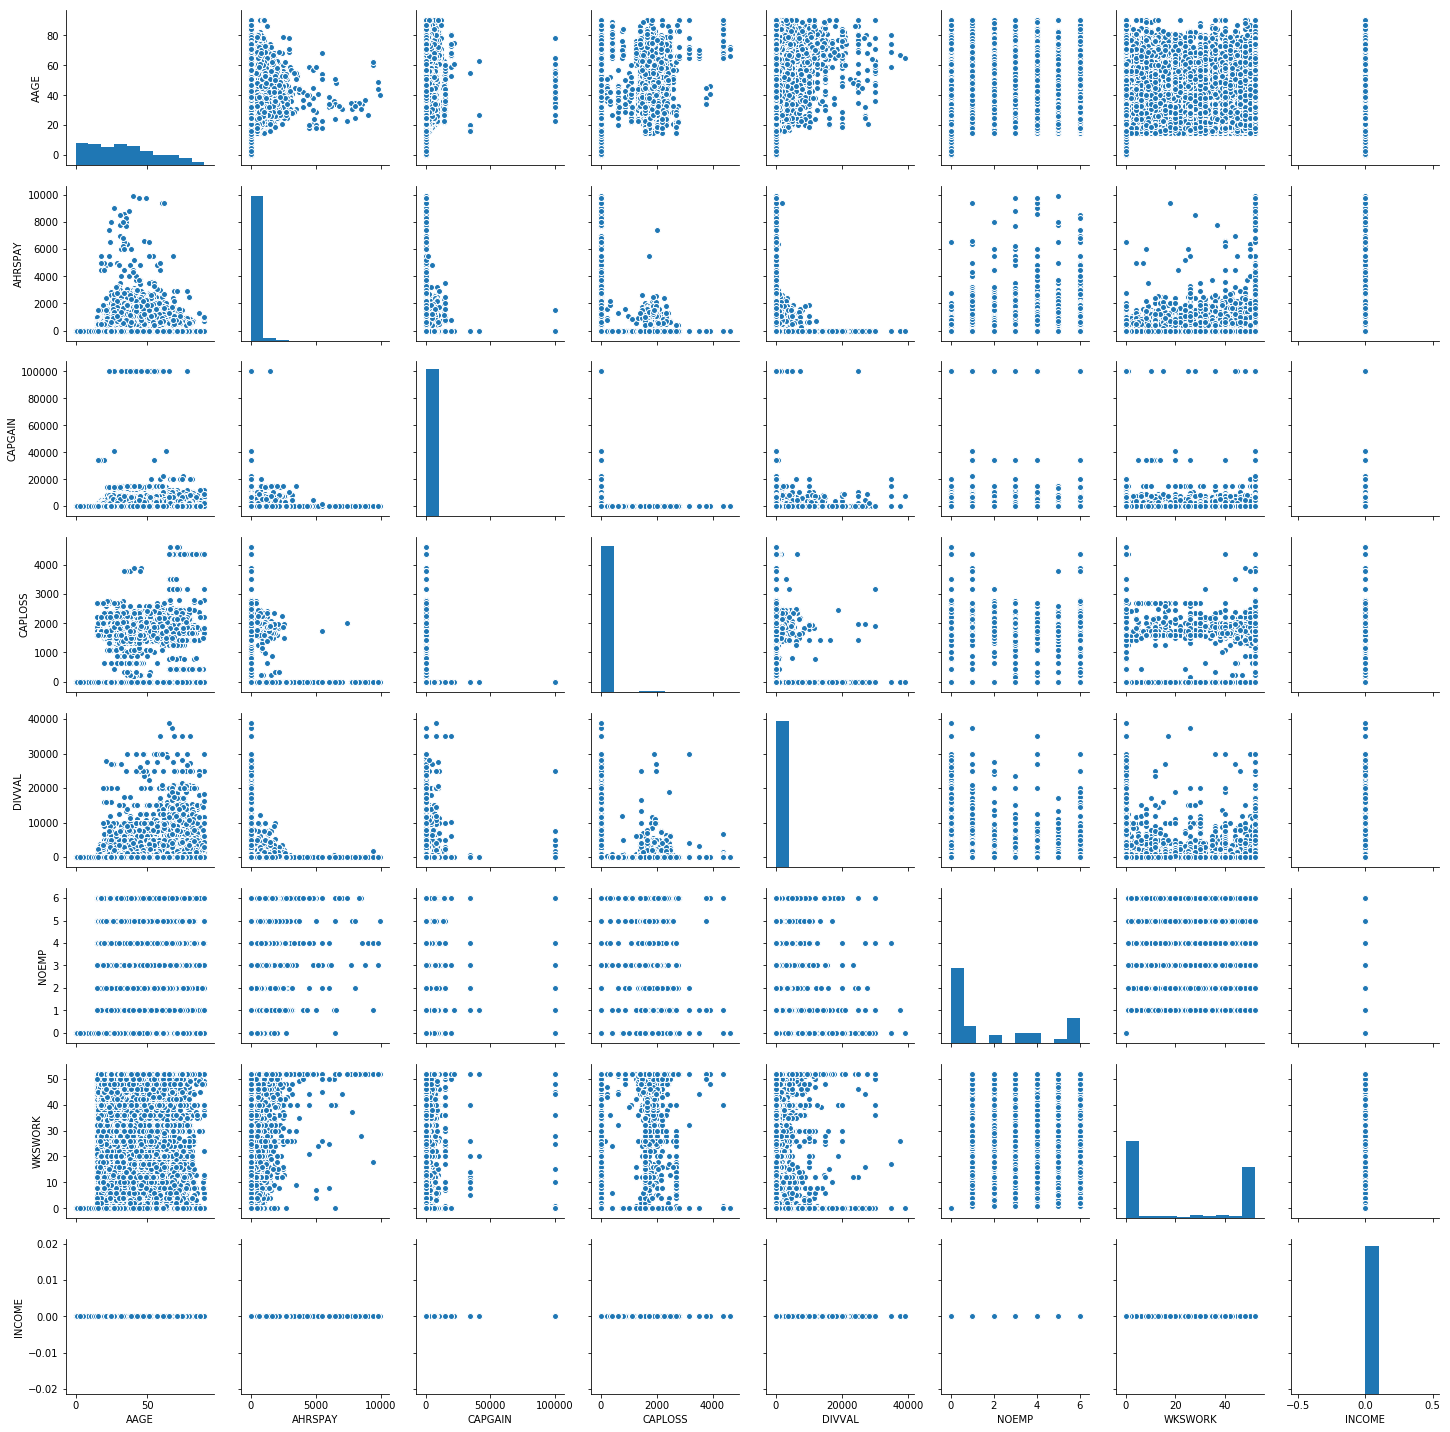

In [10]:
sns.pairplot(low_income_numerical)


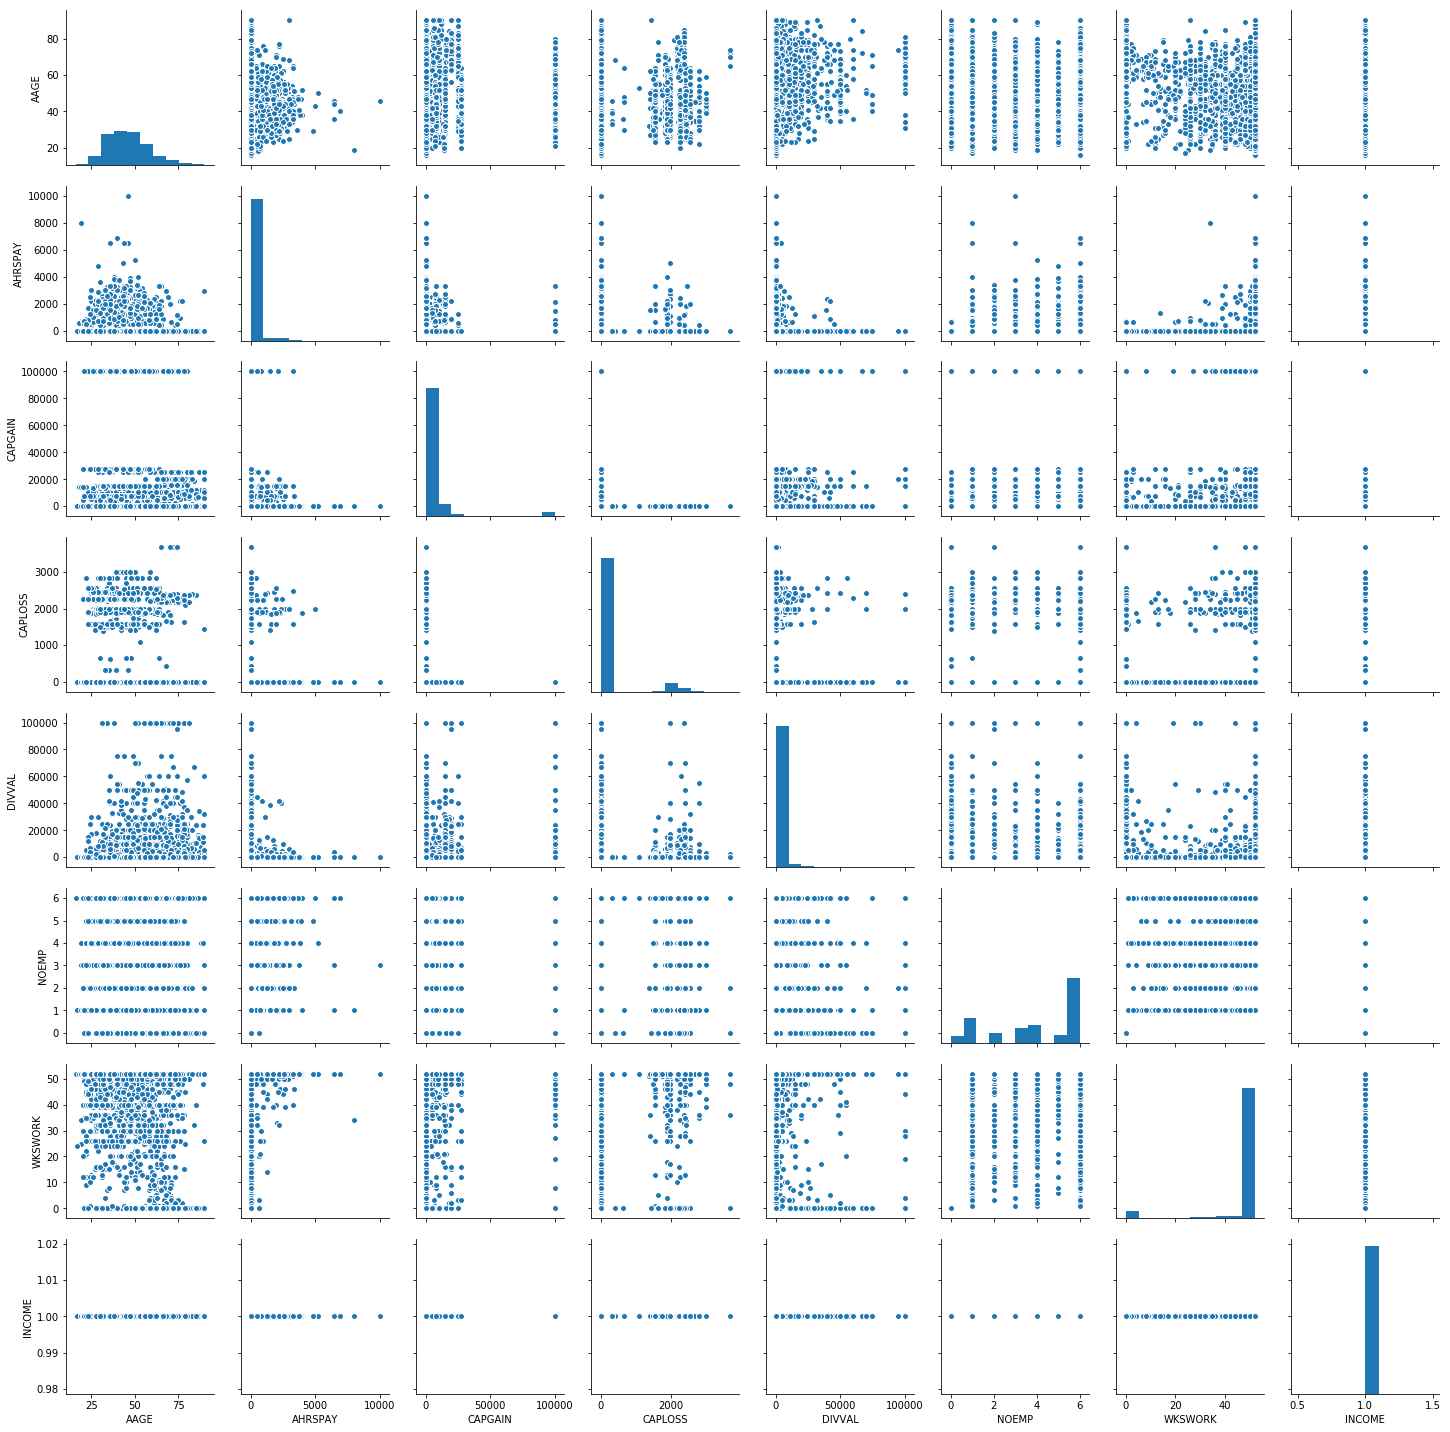

In [11]:
sns.pairplot(high_income_numerical)

### We can see that the number of employers is very correlated with the income.

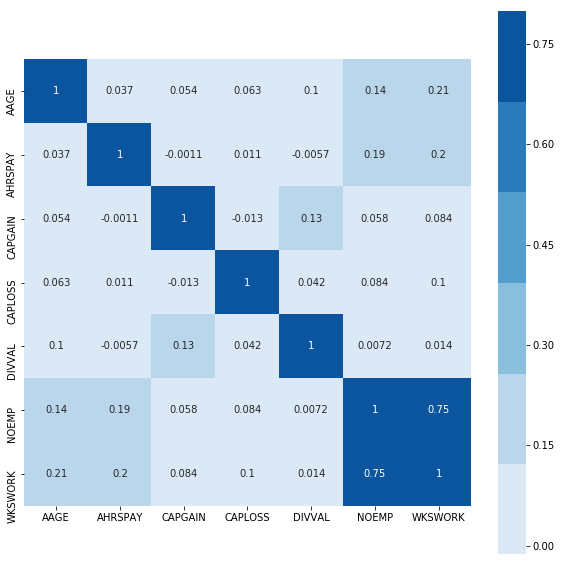

In [12]:
plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), vmax=.8,annot=True,cmap=sns.color_palette("Blues"), square=True)

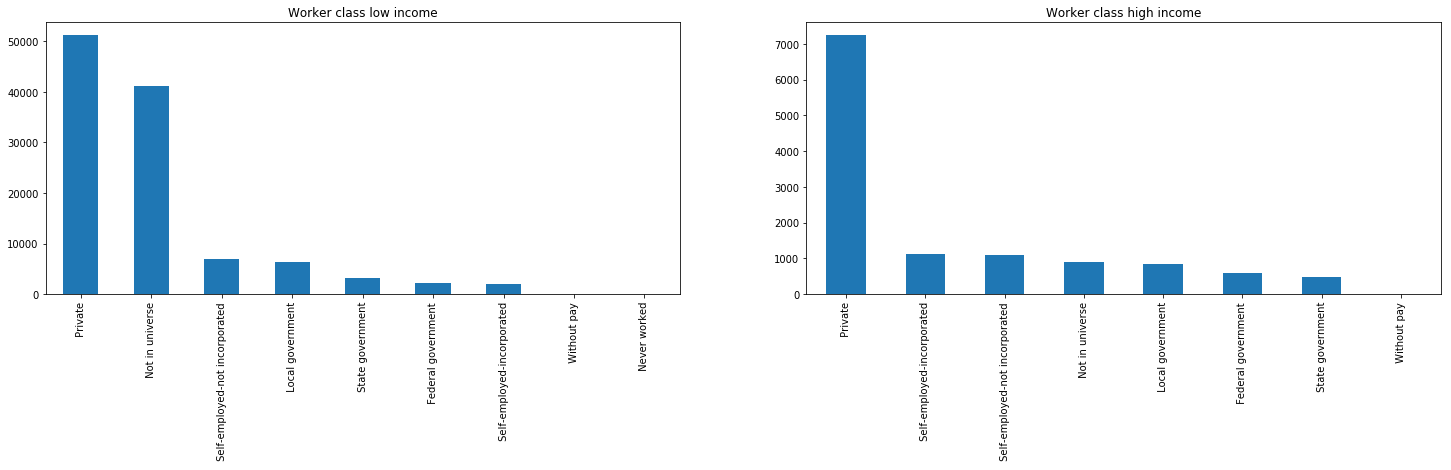

In [13]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['ACLSWKR'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Worker class'+' high income'),ax=axes[1],figsize=(25,5))
df['ACLSWKR'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Worker class'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

We can see that people with lower income are more likely to be unemployed (Not in universe)
We took age over 25 in order to remove children

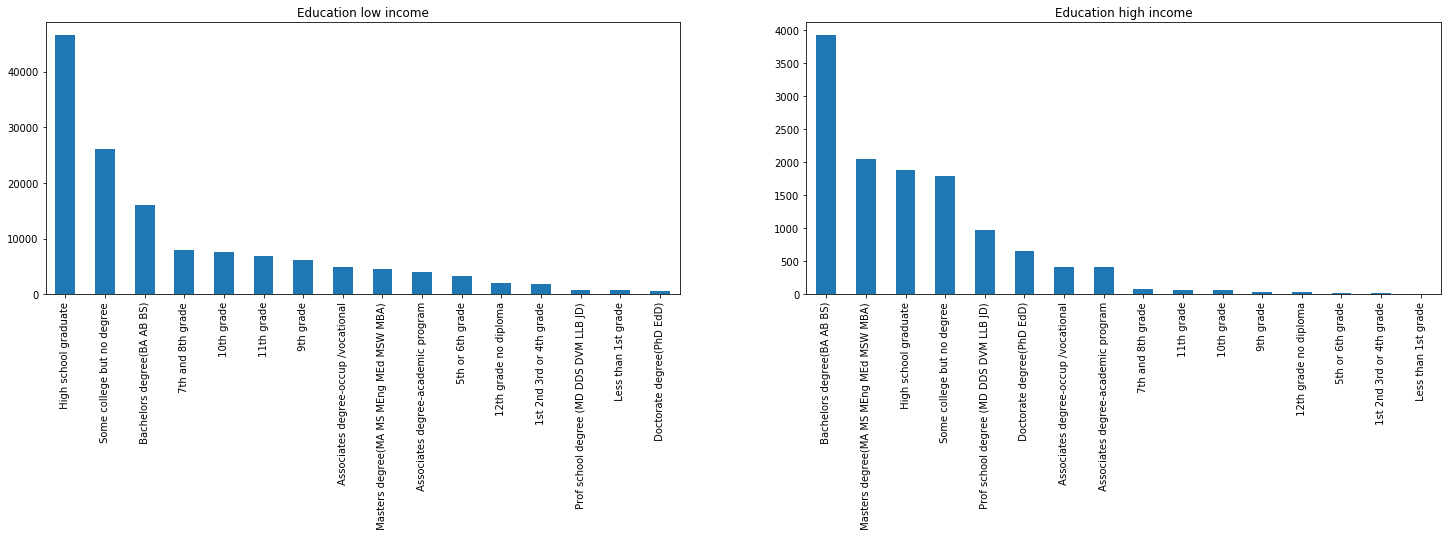

In [14]:
fig,axes=plt.subplots(nrows=1,ncols=2)

df['AHGA'].loc[(df["INCOME"]==1) & (df["AHGA"]!=" Children")].value_counts().plot(kind="bar",title=('Education'+' high income'),ax=axes[1],figsize=(25,5))

df['AHGA'].loc[(df["INCOME"]==0 ) & (df["AHGA"]!=" Children")].value_counts().plot(kind="bar",title=('Education'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()


As expected, higher income earners typically went further in their studies

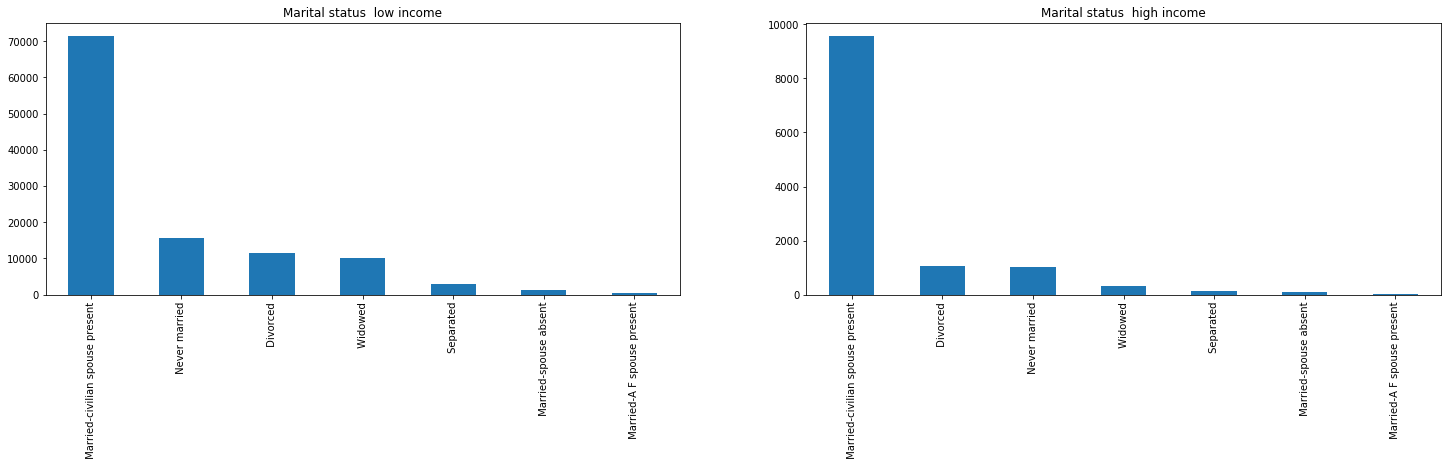

In [15]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['AMARITL'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Marital status '+' high income'),ax=axes[1],figsize=(25,5))
df['AMARITL'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Marital status '+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

This plot shows that wealthy adults are more likely to be married than lower income adults.

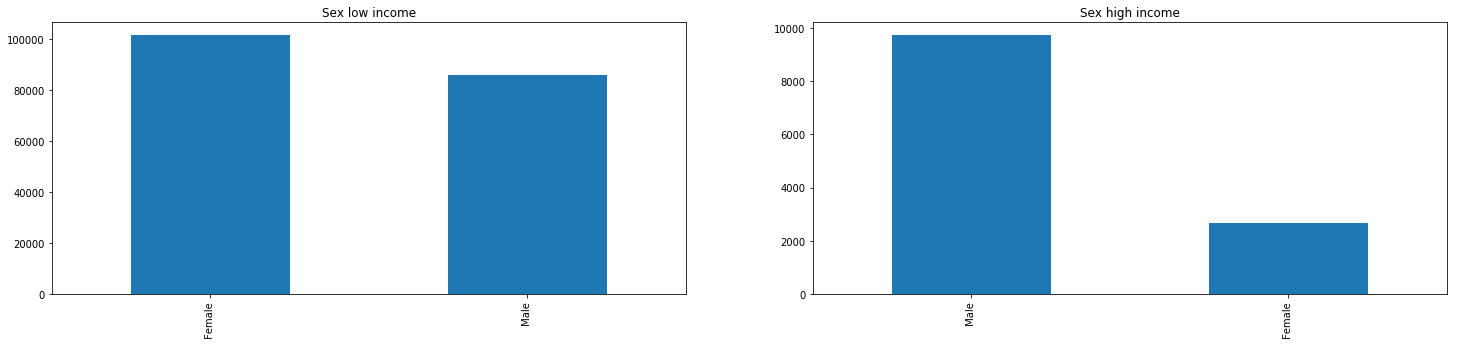

In [13]:

fig,axes=plt.subplots(nrows=1,ncols=2,sharex=False)


df['ASEX'].loc[(df["INCOME"]==1)].value_counts().plot(kind="bar",title=('Sex'+' high income'),ax=axes[1],figsize=(25,5))
df['ASEX'].loc[(df["INCOME"]==0) ].value_counts().plot(kind="bar",title=('Sex'+' low income'),ax=axes[0],figsize=(25,5))

plt.show()

In the low income bracket, women are more common than men, and in the high income bracket, men are more common than women.This plot clearly shows the wage gap between the two sexes.

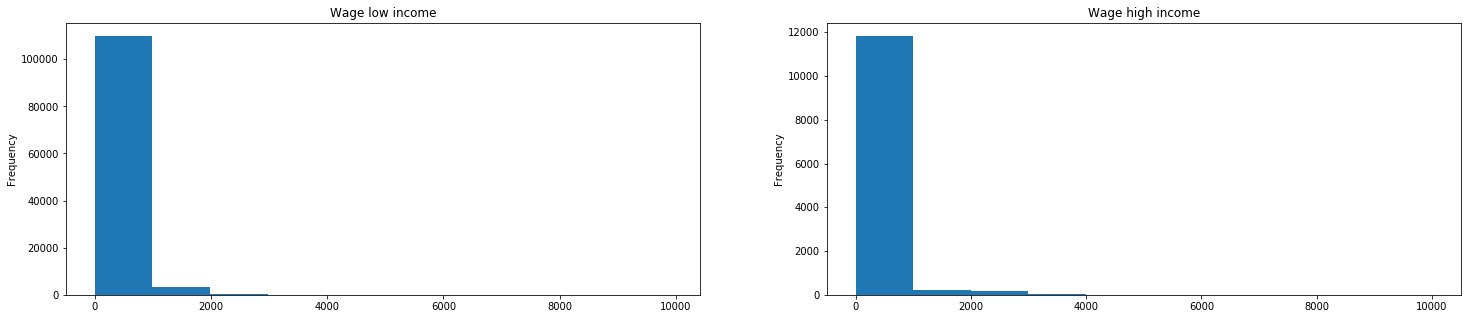

In [17]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['AHRSPAY'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].plot(kind="hist",title=('Wage'+' high income'),ax=axes[1],figsize=(25,5))
df['AHRSPAY'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].plot(kind="hist",title=('Wage'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

We see that wages tend to go in a higher range for the high income earners, however, the count shows that 188 218 survey respond stated their hourly wage was 0 , which shows this question is not answered very much, maybe for privacy reasons.

# Features processing 

#### Null values 

We are going to impute the most frequent answers , to questions that were not answered 

People who did not answer about their hispanic origin

In [18]:
df["AREORGN"].value_counts()

 All other                    171906
 Mexican-American               8079
 Mexican (Mexicano)             7234
 Central or South American      3895
 Puerto Rican                   3313
 Other Spanish                  2485
 Cuban                          1126
 NA                              874
 Do not know                     306
 Chicano                         304
Name: AREORGN, dtype: int64

In [19]:
df["AREORGN"].loc[df["AREORGN"]==' NA']= df["AREORGN"].value_counts().index[0]

c:\users\alexmonlou\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


We will first create a column which represents the net capital,which comprises of the gains and losses.

In [20]:
df["CAPGAIN"]=df["CAPGAIN"]-df["CAPLOSS"]
df.drop(columns=["CAPLOSS"],inplace=True)
df["CAPGAIN"].rename("CAPNET")

df_test["CAPGAIN"]=df_test["CAPGAIN"]-df_test["CAPLOSS"]
df_test.drop(columns=["CAPLOSS"],inplace=True)
df_test["CAPGAIN"].rename("CAPNET")

numerical[2]="CAPNET"
numerical.remove("CAPLOSS")

We will drop the wage column, because very it has a very low correlation with income and most people chose not to report their wage .  
We will keep the industry and occapation recodes which are more precise than the major industry and major occupation codes.
We drop previous region and state because of the high rate of Not in universe and low correlations with labels.
We drop migration codes (missing values, unknown values and uncorrelated to labels).
Household summary in household is dropped  as it contains less information than detailed household and family stat.
Country of birth,country of birth father and mother are dropped,most values are USA,it is not useful data and will add many variables to the model. 
We drop citizenship ,low correlation, mostly and does not differentiate foreign countries.
Use to live in Sunbelt is dropped : most of the values are missing or unknown. 
eteran questionnaire is discarded as most values are not in universe. 
The year is dropped as it has no correlation with the income category (Pearson correlation 0.005)

In [21]:
correlation=x_train=pd.get_dummies(df.drop(columns=["AHRSPAY","AMJIND","AMJOCC","GRINREG","GRINST","HHDREL","MIGMTR1","MIGMTR3","MIGMTR4","MIGSUN","PEFNTVTY","PEMNTVTY","PENATVTY","PRCITSHP","VETQVA","YEAR"]),drop_first=True).corr()
correlation["INCOME_1"].loc[(correlation["INCOME_1"]>=0.2) | (correlation["INCOME_1"]<=-0.2)]

CAPGAIN                          0.231635
NOEMP                            0.222683
WKSWORK                          0.262316
ACLSWKR_ Not in universe        -0.220913
ADTOCC_2                         0.230988
FILESTAT_ Joint both under 65    0.205192
HHDFMX_ Householder              0.213482
INCOME_1                         1.000000
Name: INCOME_1, dtype: float64

The variables most correlated to wealthiness are the number of worked weeks in a year, occupation, capital gains, number of employers in the past. Also the fact that a person does not work is very discriminative and shows a high probability of earning a low income.

# Classification 

In [22]:
concat=pd.concat([df,df_test])
concat.drop(columns=["AHRSPAY","AMJIND","AMJOCC","GRINREG","GRINST","HHDREL","MIGMTR1","MIGMTR3","MIGMTR4","MIGSUN","PEFNTVTY","PEMNTVTY","PENATVTY","PRCITSHP","VETQVA","YEAR","INCOME"],inplace=True)
dummies=pd.get_dummies(concat,drop_first=True)
x_train=dummies[:len(df)]
x_test=dummies[len(df):]

x_train.info()
x_test.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199522 entries, 0 to 199521
Columns: 214 entries, AAGE to VETYN_2
dtypes: int64(5), uint8(209)
memory usage: 48.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99761 entries, 0 to 99760
Columns: 214 entries, AAGE to VETYN_2
dtypes: int64(5), uint8(209)
memory usage: 24.5 MB


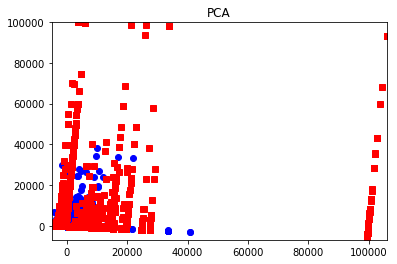

In [23]:

def plot_2d(X, y,title=''):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y """
    plt.figure()
    symlist = ['o', 's', '*', 'x', 'D', '+', 'p', 'v', 'H', '^']
    collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
               'fuchsia']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1], '+',
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.title(title)
    plt.show()
    
# We use PCA to get a 2D representation of our data
pca = decomposition.PCA(n_components=2)
X_2D = pca.fit_transform(x_train)

plot_2d(X_2D, y_train,'PCA')

This plot shows that the classes are overlapping with a 2 component PCA. The features that are going to be discriminative will have a low signal 

### Logistic regression 

The advantage of logistic regression is that it is robust to outliers, is interpretable because it outputs a probability of belonging to each class .Furthermore, it's weights show the influence of each feature on the output probability ! 

In [24]:
param_grid = {
              'penalty': ['l1','l2'],
    'C':[0.5,1,2]
             }

lr_gs = model_selection.GridSearchCV(LogisticRegression(), param_grid,scoring='f1',cv=3)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_params_)

{'C': 2, 'penalty': 'l1'}


The grid search enables to choose good parameters for our logistic regressor. We will choose the best parameters found in the future. We will now fit our model and make predictions using  L1 regression , lasso.
The advantage of Lasso is that it does feature selection, and discards variables with low influence on classification.

In [25]:
model_logistic=LogisticRegression(C=2,penalty='l1')
classifier=model_logistic

In [26]:
classifier.fit(x_train,y_train)
predictions_logistic=classifier.predict( x_test)

print(confusion_matrix(y_test,predictions_logistic))
print(classification_report(y_test, predictions_logistic))

[[92633   942]
 [ 5705   481]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     93575
          1       0.34      0.08      0.13      6186

avg / total       0.90      0.93      0.91     99761



In [31]:
feature_weights=dict(zip(x_train.columns,model_logistic.coef_[0]))
sorted(feature_weights.items(), key=lambda item: -abs(item[1]))[:20]

[('AHGA_ Children', -5.305245319378595),
 ('VETYN_2', -3.736781899919186),
 ('VETYN_1', -3.2898029128548765),
 ('AHGA_ Doctorate degree(PhD EdD)', 2.915367163758126),
 ('HHDFMX_ Child <18 never marr not in subfamily', -2.684397059775115),
 ('AHGA_ Prof school degree (MD DDS DVM LLB JD)', 2.6163767672294727),
 ('PARENT_ Not in universe', -2.347711038009961),
 ('AHGA_ Masters degree(MA MS MEng MEd MSW MBA)', 2.310468101209681),
 ('ADTIND_20', 1.7706234524500146),
 ('FILESTAT_ Nonfiler', -1.7545624566854285),
 ('AHGA_ Bachelors degree(BA AB BS)', 1.7318671595169957),
 ('HHDFMX_ Spouse of RP of unrelated subfamily', 1.685467767672562),
 ('ADTOCC_7', 1.559775956600364),
 ('ADTOCC_31', -1.5415487152146943),
 ('ADTOCC_11', 1.3892219311747713),
 ('ADTIND_26', 1.3760937618105784),
 ('ADTOCC_29', -1.263042183949428),
 ('ADTOCC_42', -1.1452357812312823),
 ('AHGA_ Associates degree-academic program', 1.133705575341464),
 ('ADTOCC_27', -1.0884945433517677)]

Let's look at the first 8 lines (the most influencial categorical variables).
We can see that having a PhD , a Professor's degreee, or a Master's helps the most to be more wealthy (Positive correlation) . We also show that there are 2 occupations ( code 29 and 31) that do not help getting to 50K.

### Trying to fix the class imbalance

In [32]:
param_grid = {
              'penalty': ['l1','l2'],
    'C':[0.5,1,2],
    'class_weight':['balanced',None]
             }

lr_gs = model_selection.GridSearchCV(LogisticRegression(), param_grid,scoring='accuracy',cv=3)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_params_)

{'C': 1, 'class_weight': None, 'penalty': 'l1'}


In [33]:
param_grid = {
              'penalty': ['l1','l2'],
    'C':[0.5,1,2],
    'class_weight':['balanced',None]
             }

lr_gs = model_selection.GridSearchCV(LogisticRegression(), param_grid,scoring='f1',cv=3)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_params_)

{'C': 2, 'class_weight': None, 'penalty': 'l1'}


It is not optimal to rebalance the dataset, so we will keep our original dataset.

### Random Forest 

The advantage of the random forest algorithm is that it is a very robust aggregating algorithm, which limits the variance.Aggregating several trees decreases the variance and the bias .The random feature selection in the algorithm also decreases variance. The model is interpretable, because we can visualise the tree to see the splits and gain knowledge.  

In [34]:
param_grid = {'n_estimators':[100],
              'max_depth': [None,5,10,15,20],
             }

rf_gs = model_selection.GridSearchCV(RandomForestClassifier(), param_grid,scoring='f1',cv=3)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_params_)

{'max_depth': None, 'n_estimators': 100}


In [35]:
random_forest=RandomForestClassifier(n_estimators=100, criterion='gini',
                                     max_depth=None, min_samples_split=2,
                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None, 
                                     bootstrap=True, 
                                     n_jobs=-1, random_state=42, 
                                    )
classifier=random_forest

In [36]:
classifier=classifier.fit(x_train,y_train)
predictions_rf=classifier.predict( x_test)

print(confusion_matrix(y_test,predictions_rf))
print(classification_report(y_test, predictions_rf))

[[92822   753]
 [ 5684   502]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     93575
          1       0.40      0.08      0.13      6186

avg / total       0.91      0.94      0.91     99761



Text(0.5,1,'A visualisation of one decision tree')

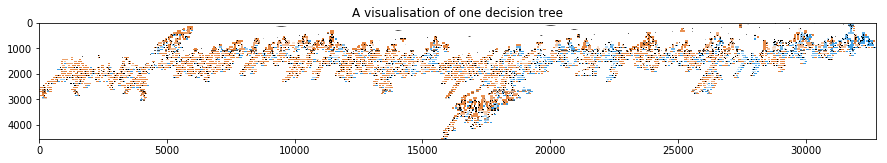

In [37]:
plt.figure(figsize=(15,15))
dot_data = tree.export_graphviz(classifier.estimators_[0], out_file='tree.dot', 
                         feature_names=x_train.columns,  
                         class_names=["Low income" , "High income" ],  
                         filled=True, rounded=True,  
                         special_characters=True) 

#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

plt.imshow(mpimg.imread('tree.png'))
plt.title("A visualisation of one decision tree")


 ### Performance 

Text(0.5,1,'Logistic regression Roc curve')

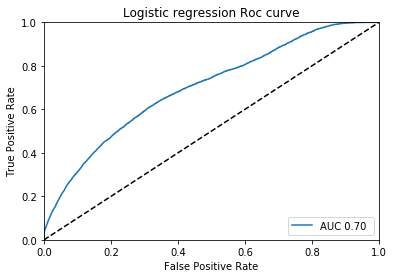

In [38]:
fpr,tpr,thresholds=roc_curve(y_test,model_logistic.predict_proba(x_test)[:,1]) #roc_auc_score curves
auc=roc_auc_score(y_test,model_logistic.predict_proba(x_test)[:,1])
plt.plot(fpr,tpr,label="AUC %.2f "%auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title("Logistic regression Roc curve")


In [39]:
#best f1 score :
probas=model_logistic.predict_proba(x_test)[:,1]
threshbest,f1best=0,0
for i in range(100):
    
    thresh=i/100
    true_pos = sum([(probas[k] > thresh) * (y_test[k] == 1) for k in range(len(probas))])
    false_pos = sum([(probas[k] > thresh) * (y_test[k] == 0) for k in range(len(probas))])
    false_neg = sum([(probas[k] <= thresh) * (y_test[k] == 1) for k in range(len(probas))])
    true_neg = sum([(probas[k] <= thresh) * (y_test[k] == 0) for k in range(len(probas))])

    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    if f1>f1best:
        f1best=f1
        threshbest=thresh
print(f1best,threshbest)

0.2224550160216909 0.09



After setting the threshold, we have a  maximum 0.22 f1 score on the test set, with a 0.09 threshold.The Area under curve score is 0.70, which means the probabilty of correctly ranking a positive-negative pair is 0.7.


Text(0.5,1,'Random Forest Roc curve')

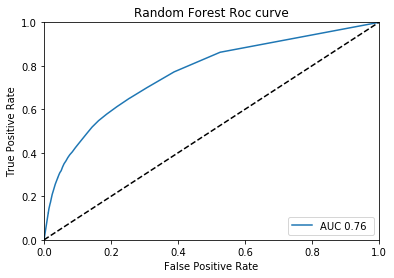

In [40]:
fpr,tpr,thresholds=roc_curve(y_test,random_forest.predict_proba(x_test)[:,1]) #roc_auc_score curves
auc=roc_auc_score(y_test,random_forest.predict_proba(x_test)[:,1])
plt.plot(fpr,tpr,label="AUC %.2f "%auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title("Random Forest Roc curve")


In [41]:
#best f1 score :
probas=random_forest.predict_proba(x_test)[:,1]
threshbest,f1best=0,0
for i in range(100):
    
    thresh=i/100
    true_pos = sum([(probas[k] > thresh) * (y_test[k] == 1) for k in range(len(probas))])
    false_pos = sum([(probas[k] > thresh) * (y_test[k] == 0) for k in range(len(probas))])
    false_neg = sum([(probas[k] <= thresh) * (y_test[k] == 1) for k in range(len(probas))])
    true_neg = sum([(probas[k] <= thresh) * (y_test[k] == 0) for k in range(len(probas))])

    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    if f1>f1best:
        f1best=f1
        threshbest=thresh
print(f1best,threshbest)

0.3104957314011048 0.16


c:\users\alexmonlou\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


# Conclusion 

Our analysis shows that the variables most correlated to wealthiness are the number of worked weeks in a year, occupation, capital gains, number of employers in the past and education. Also the fact that a person does not work is very discriminative and shows a high probability of earning a low income. The difficult part about this task was to choose which variables to keep , and which to discard . We brought clear insights to profiles of people who earn more than 50k in income.

We compared the random forest algorithm with the logistic regression algorithm, and the Random Forest algorithm had a better AUC score and F1 score.

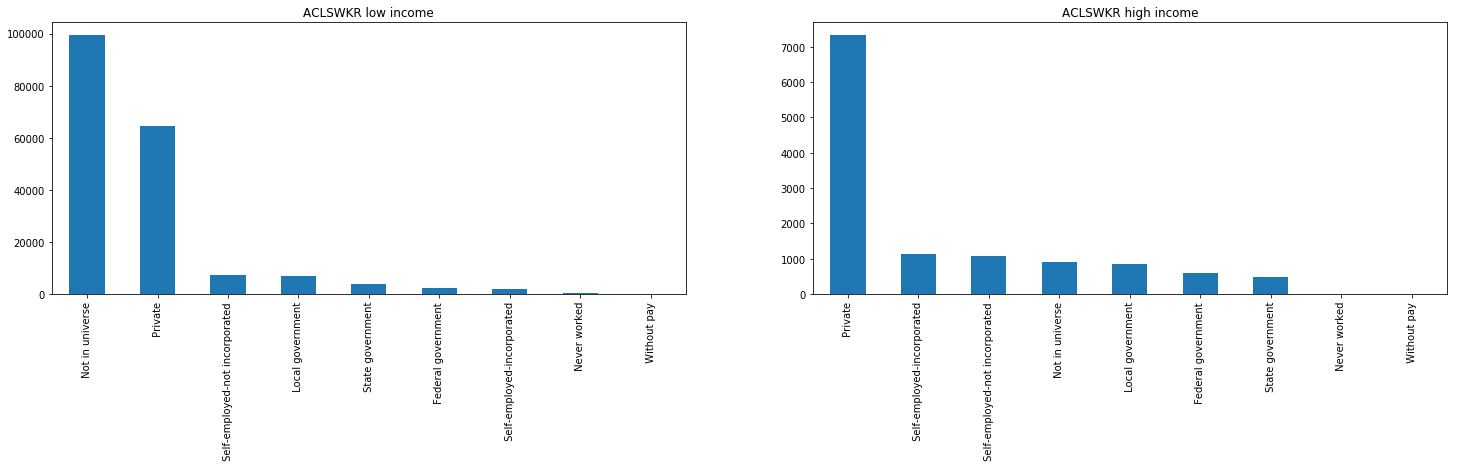

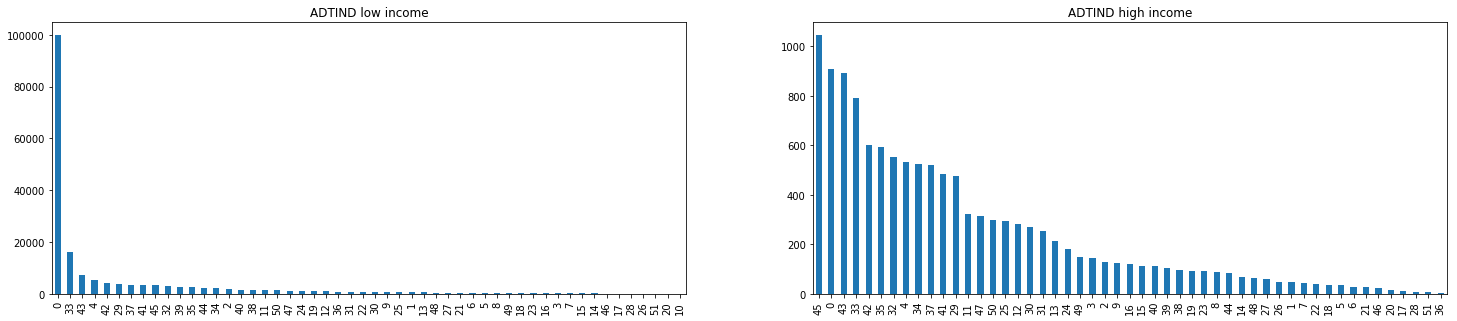

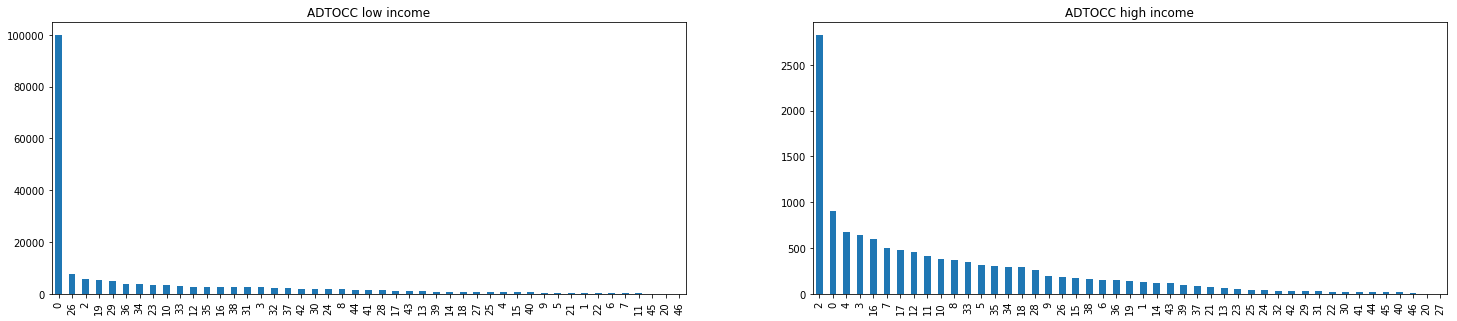

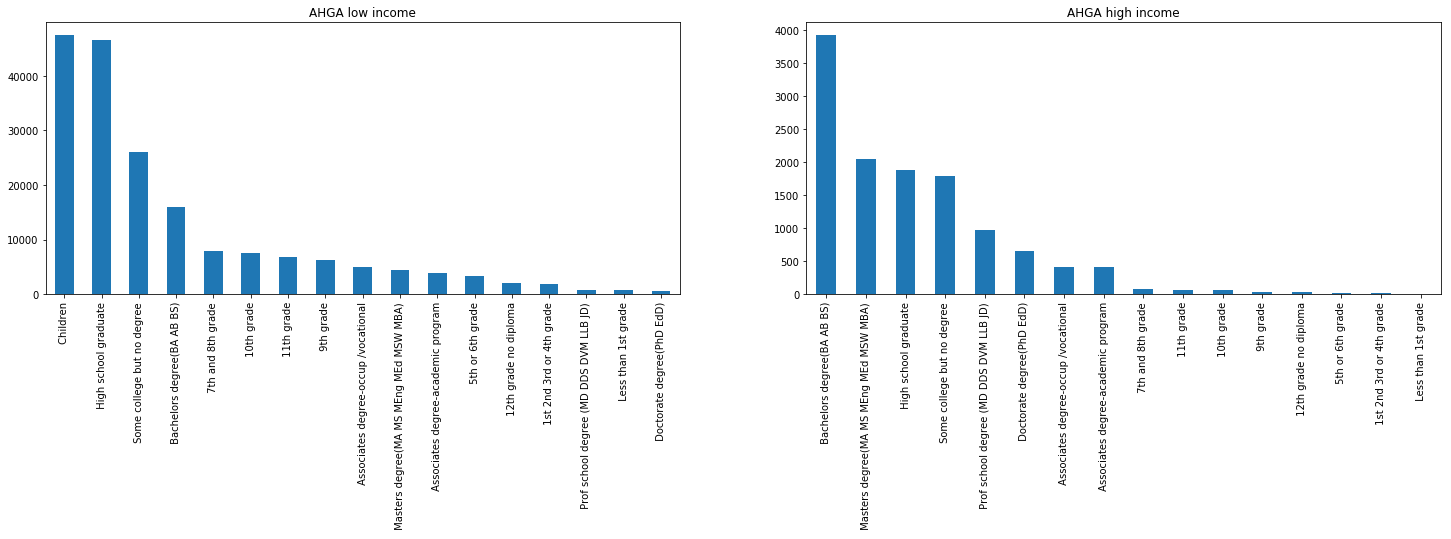

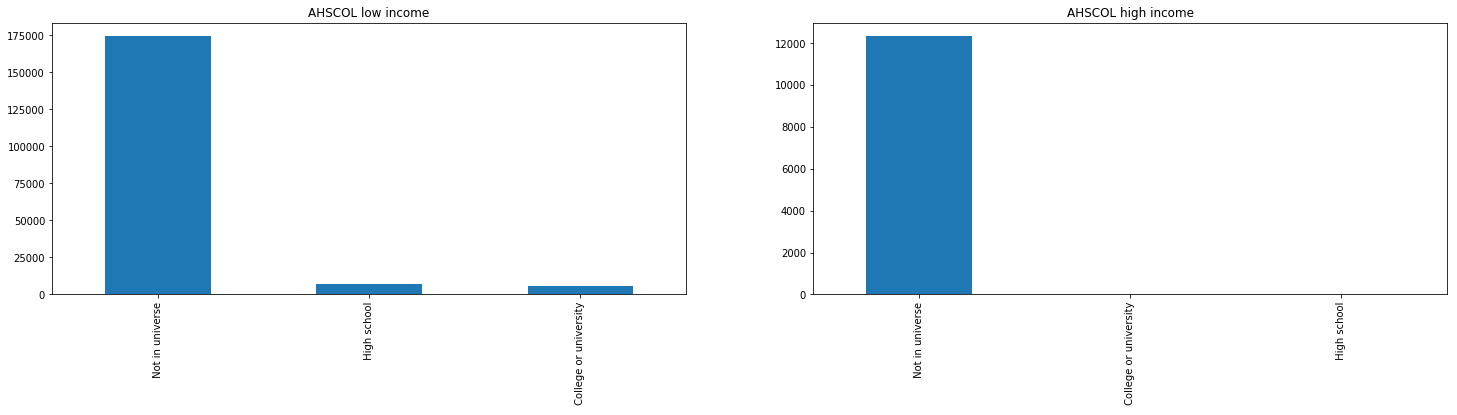

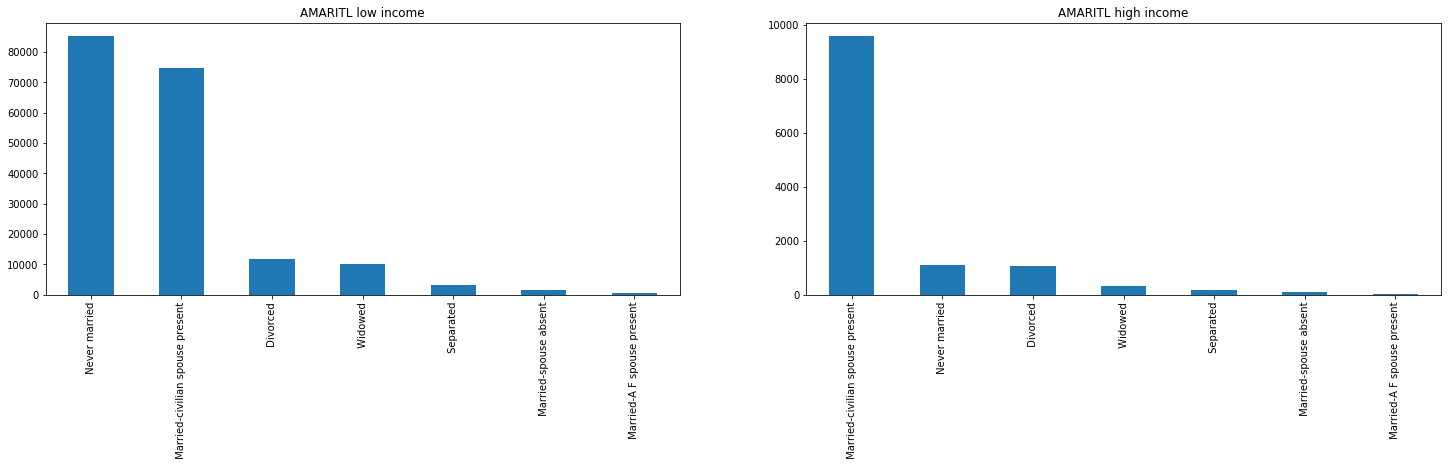

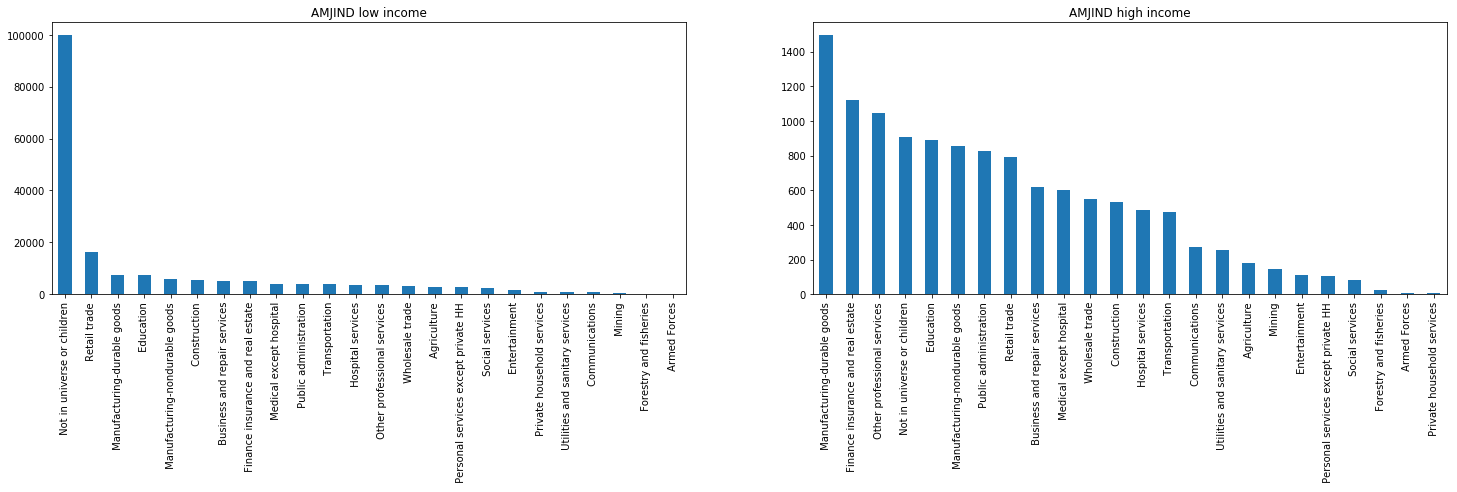

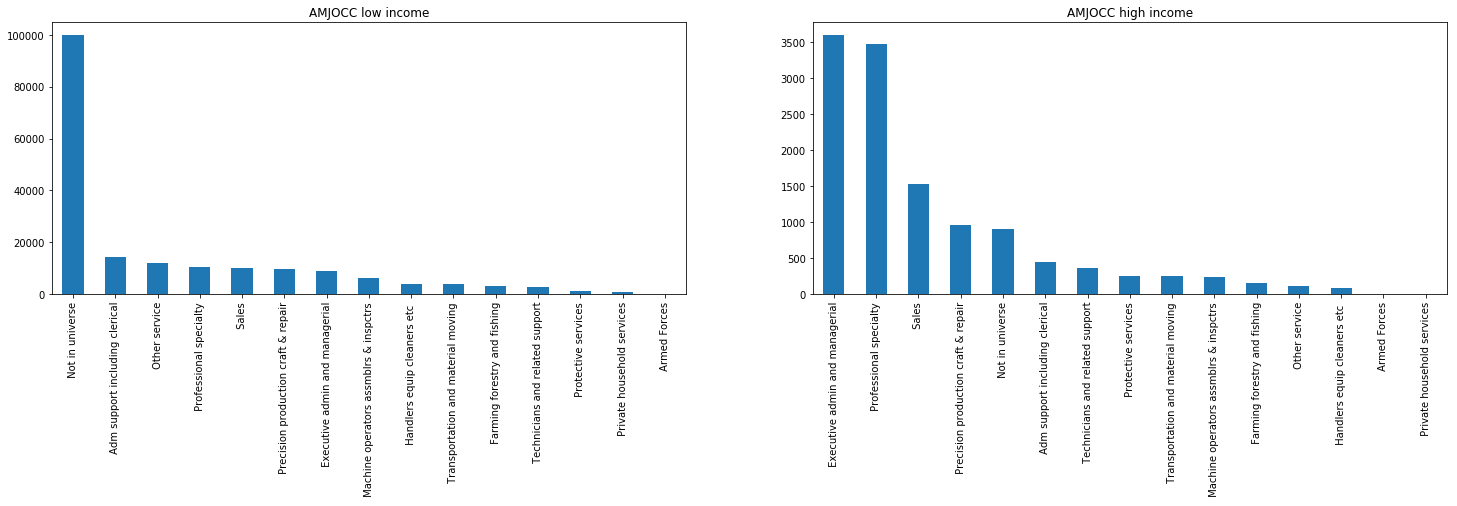

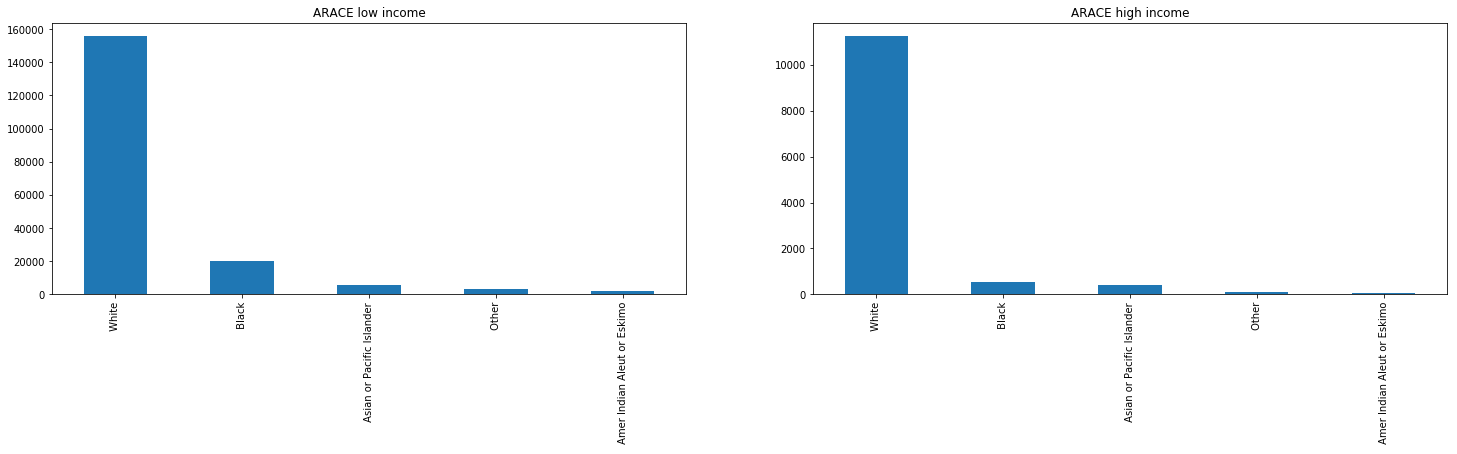

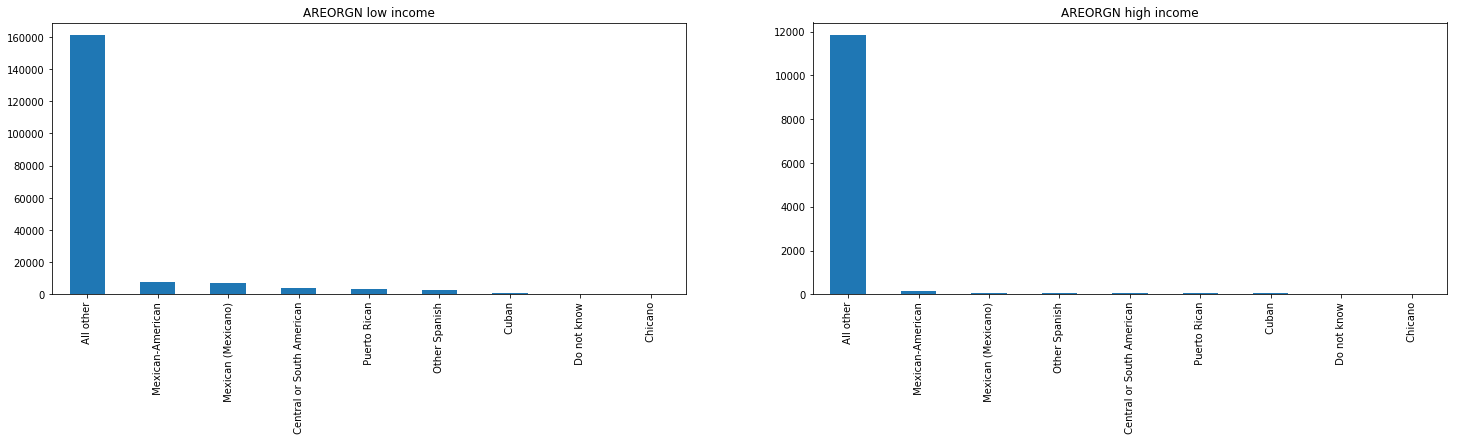

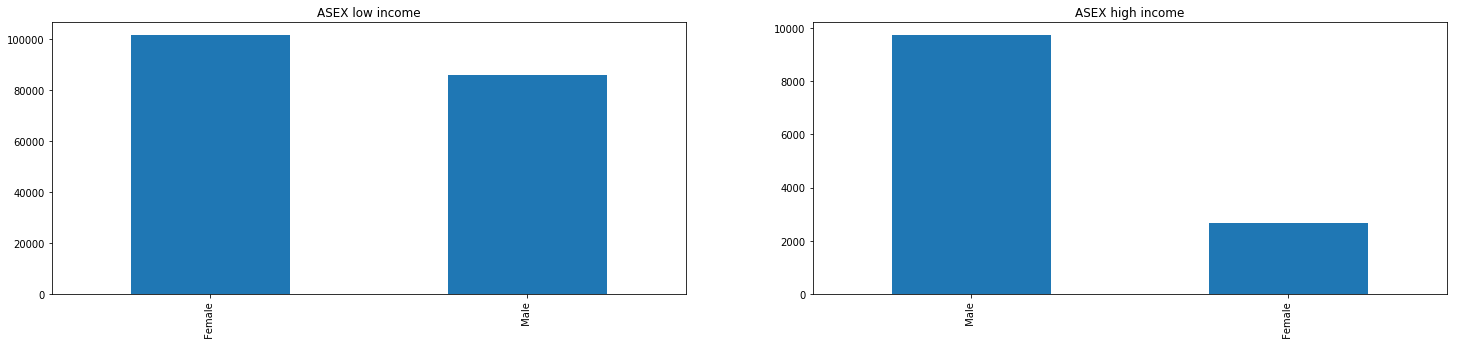

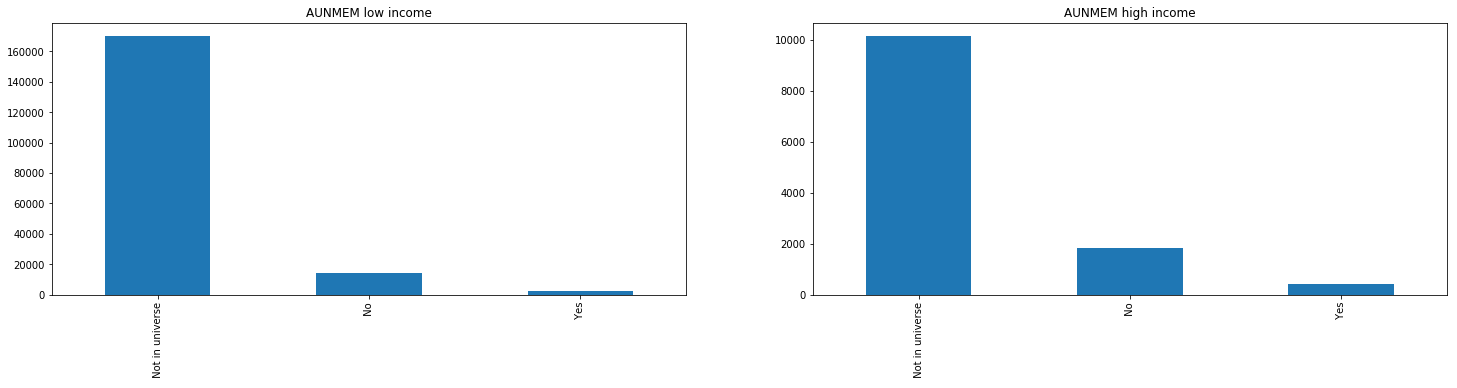

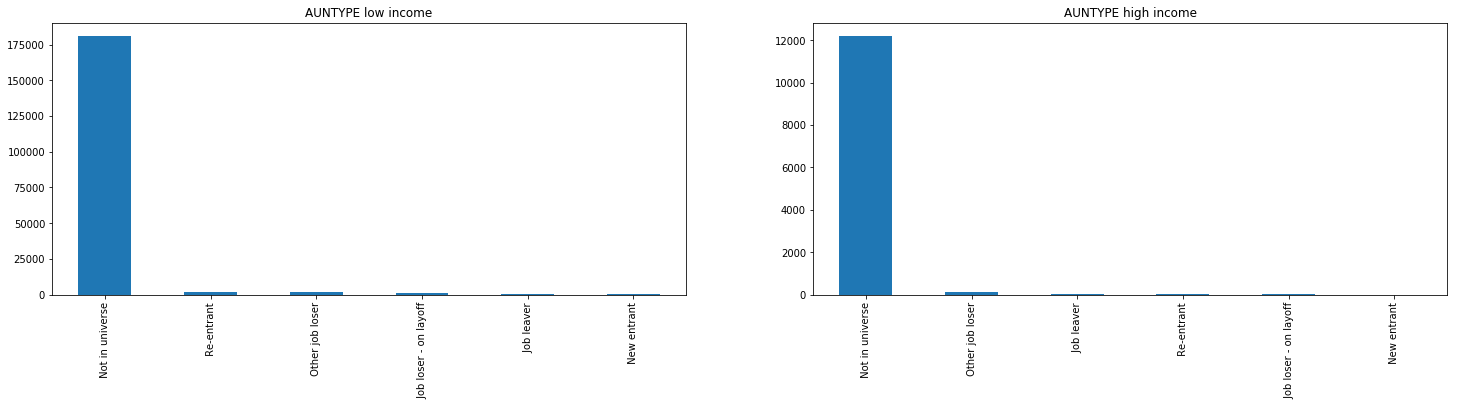

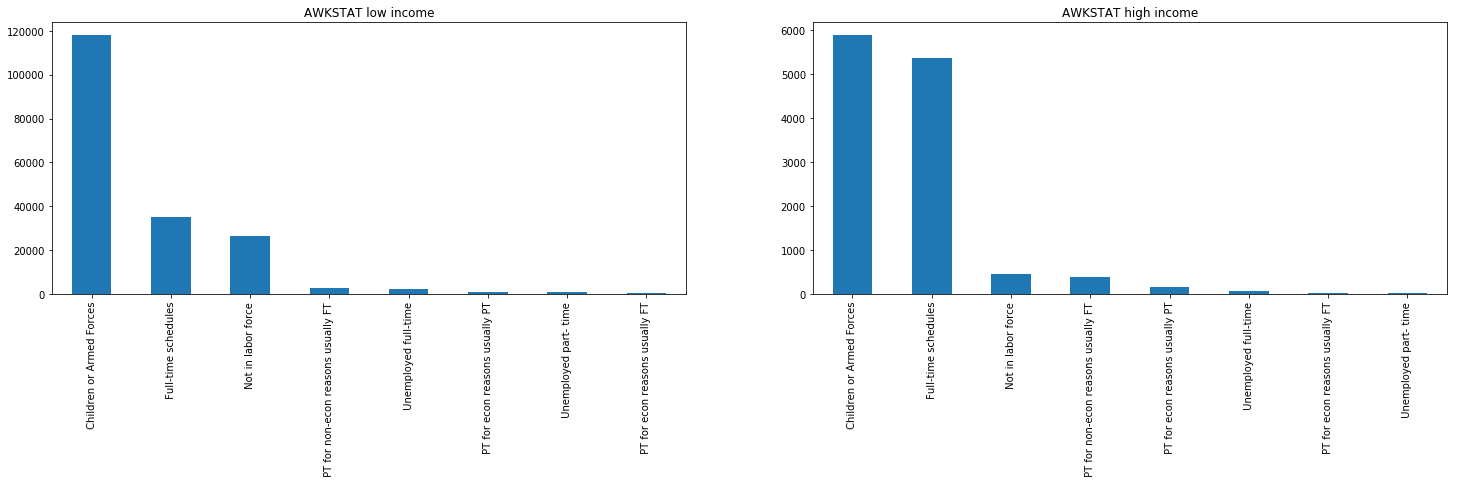

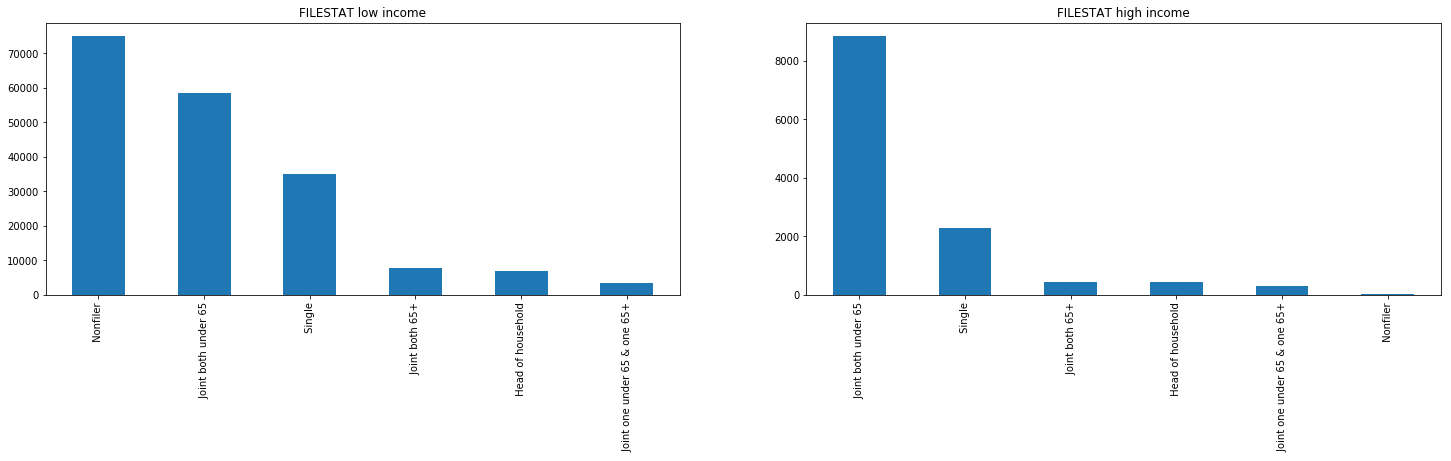

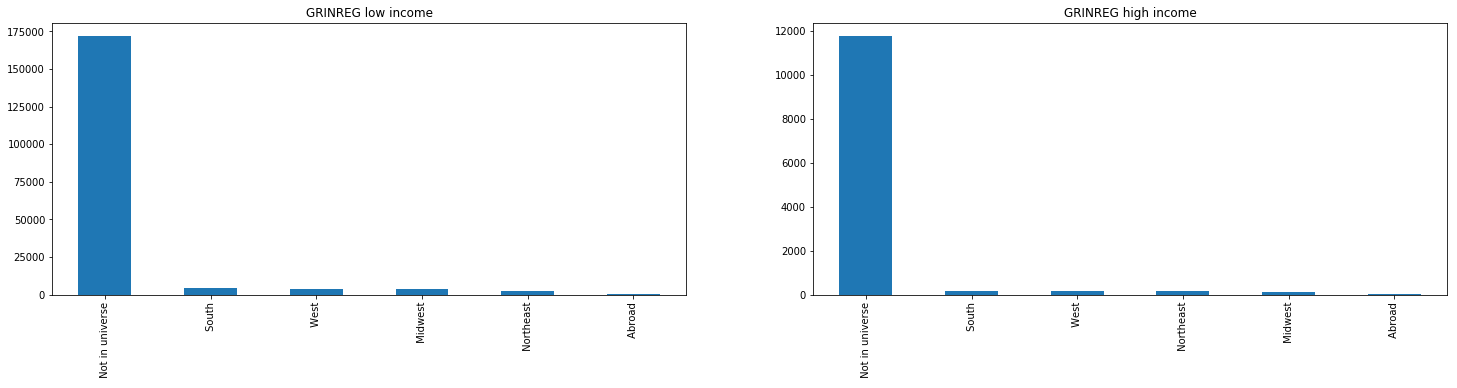

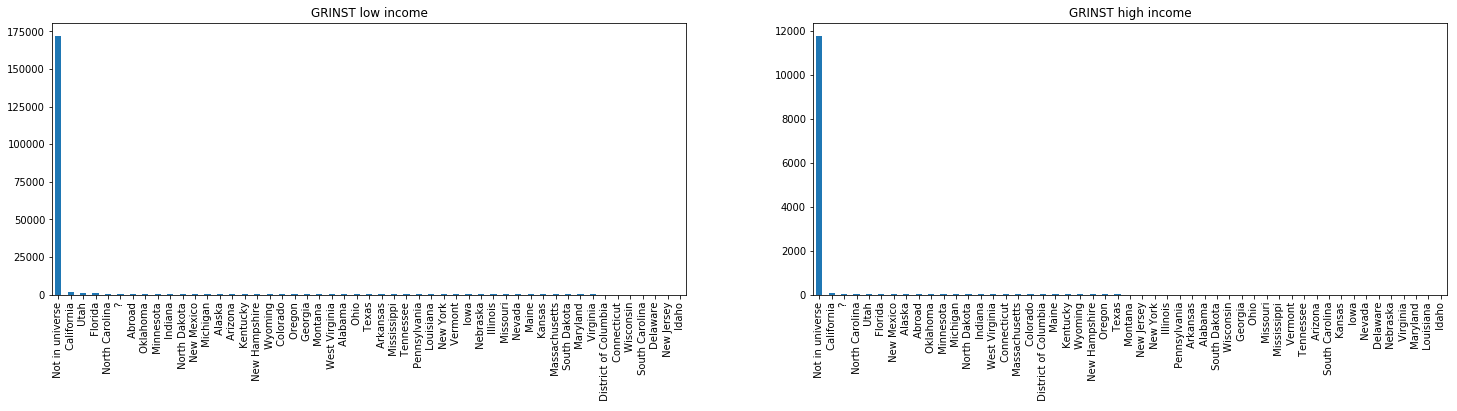

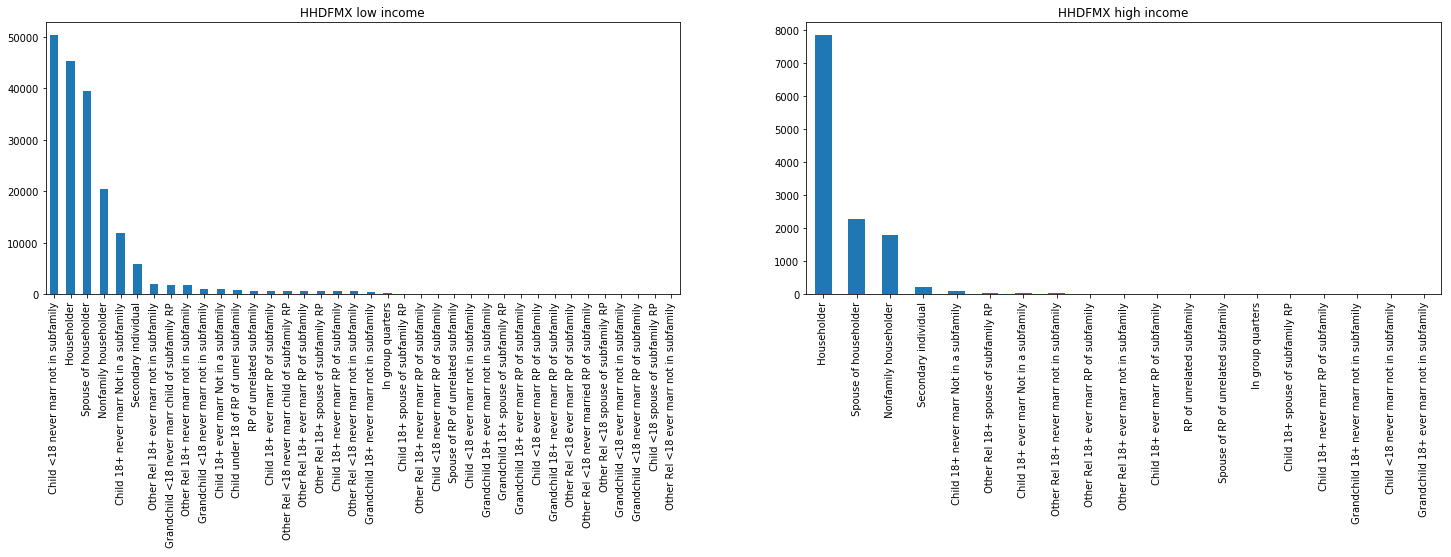

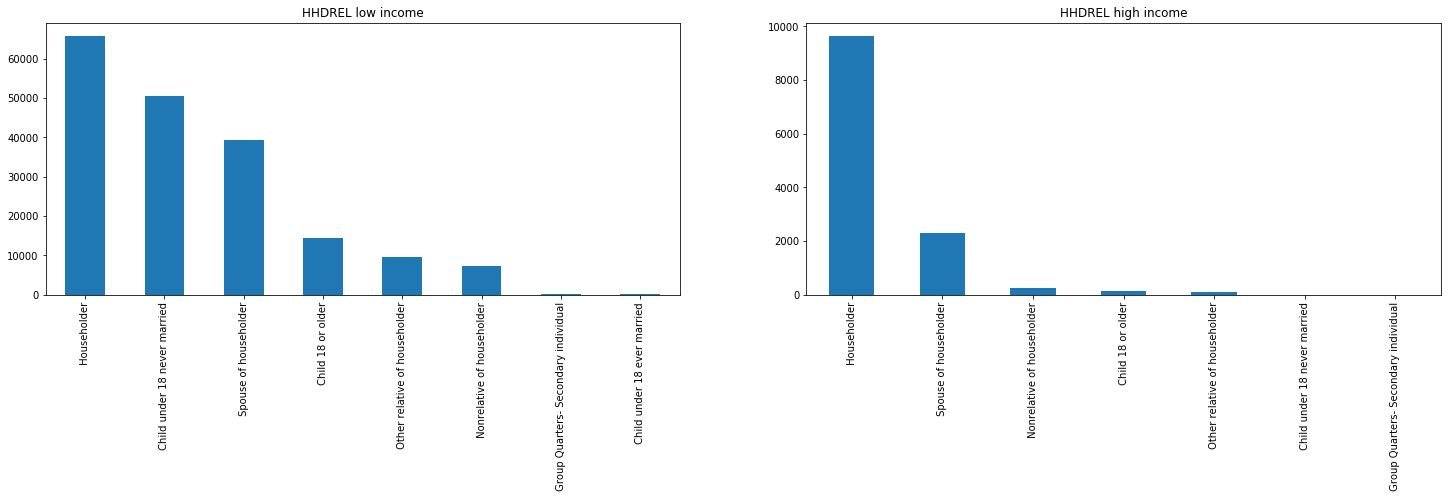

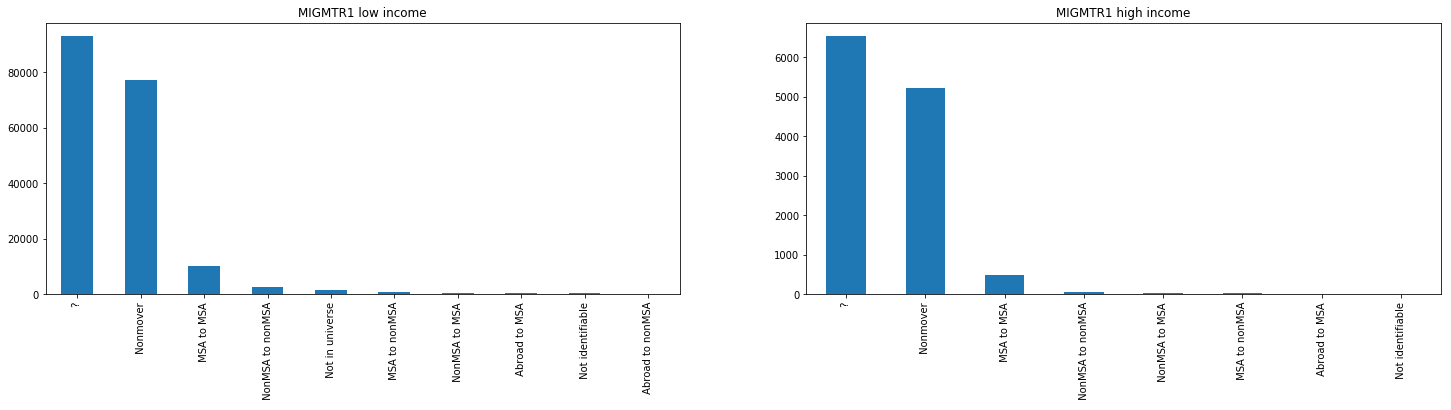

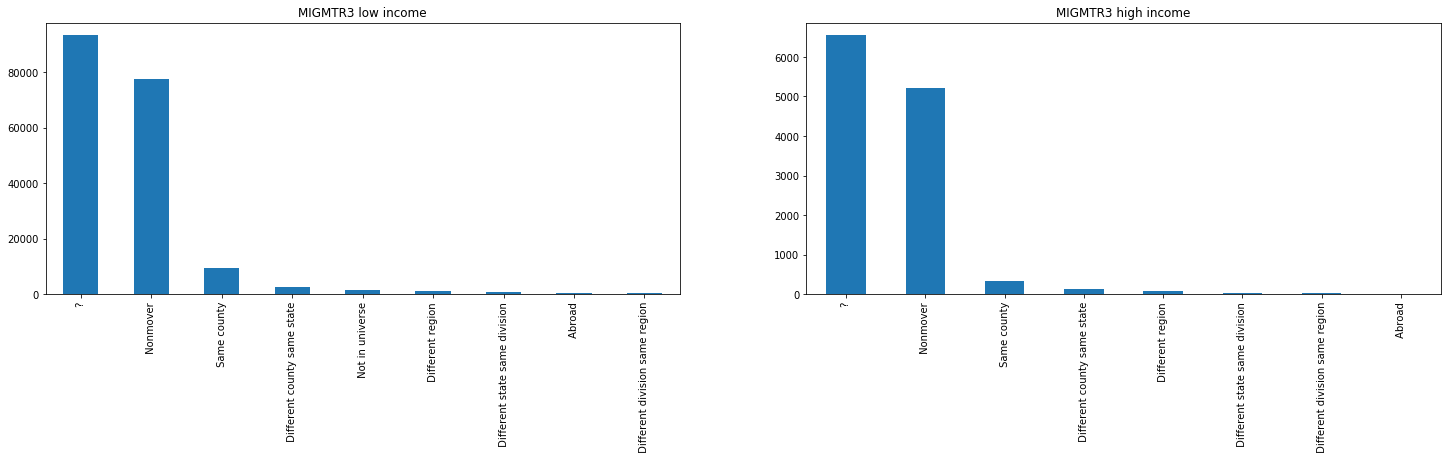

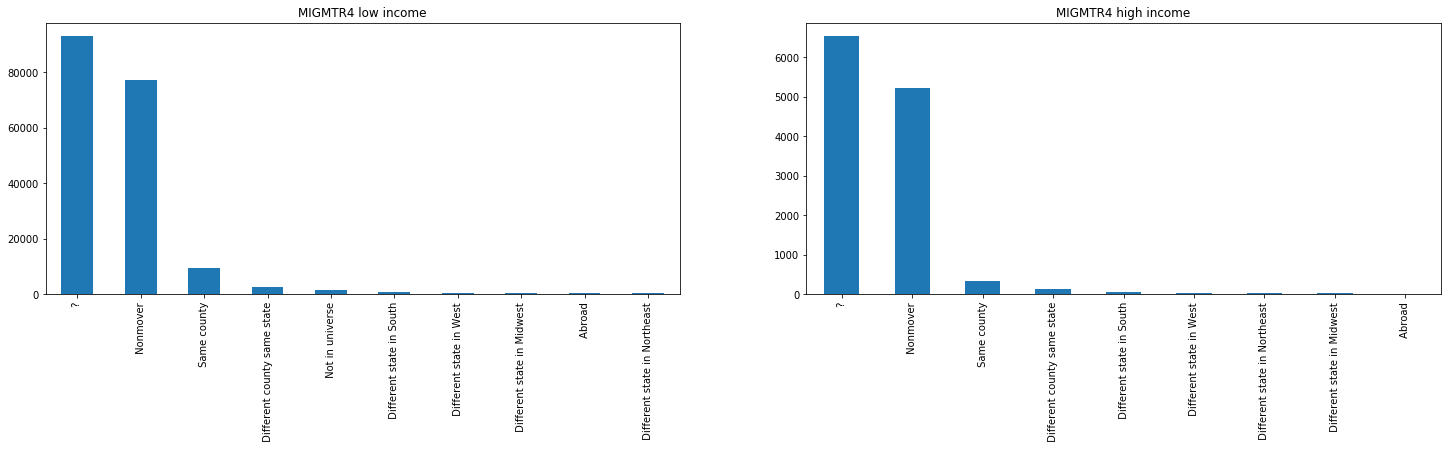

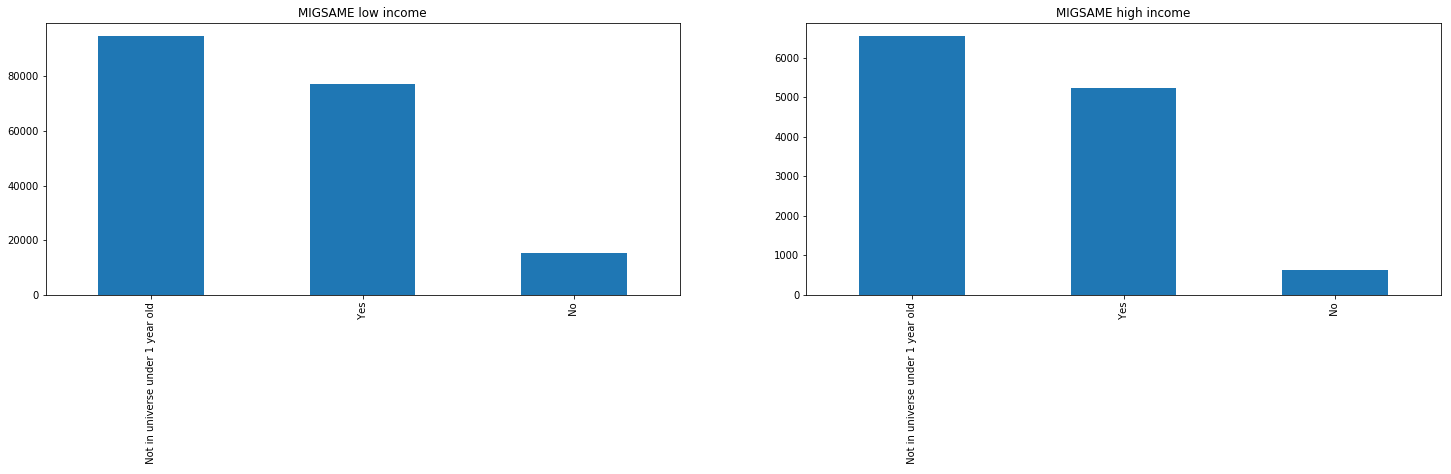

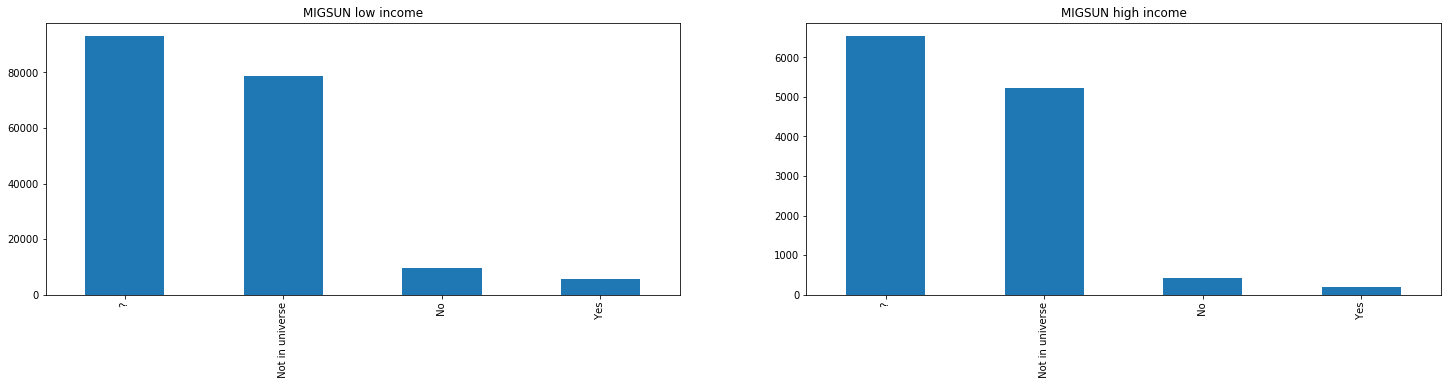

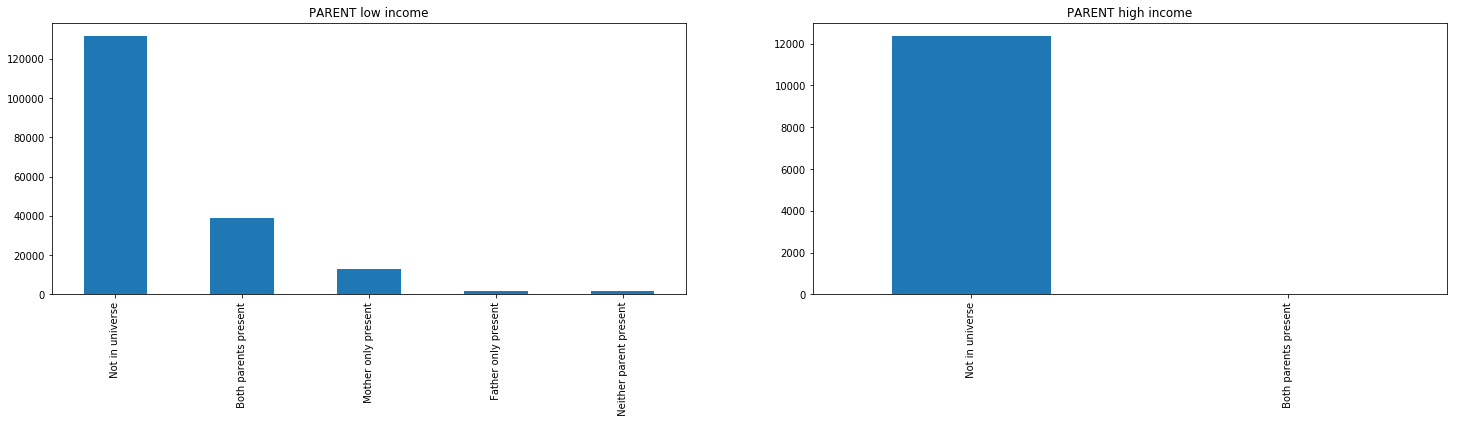

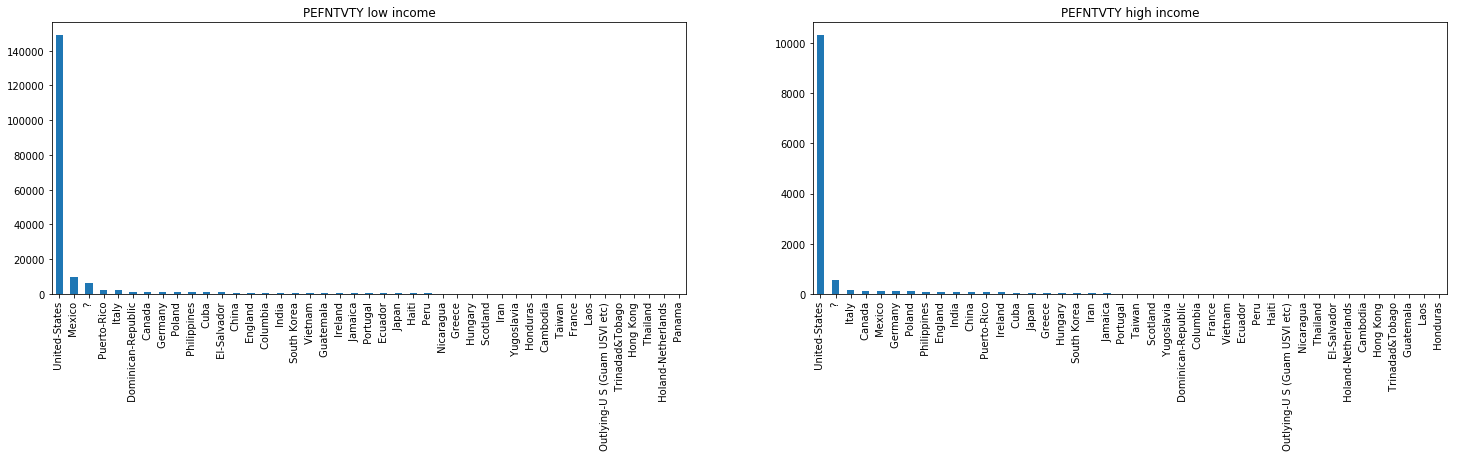

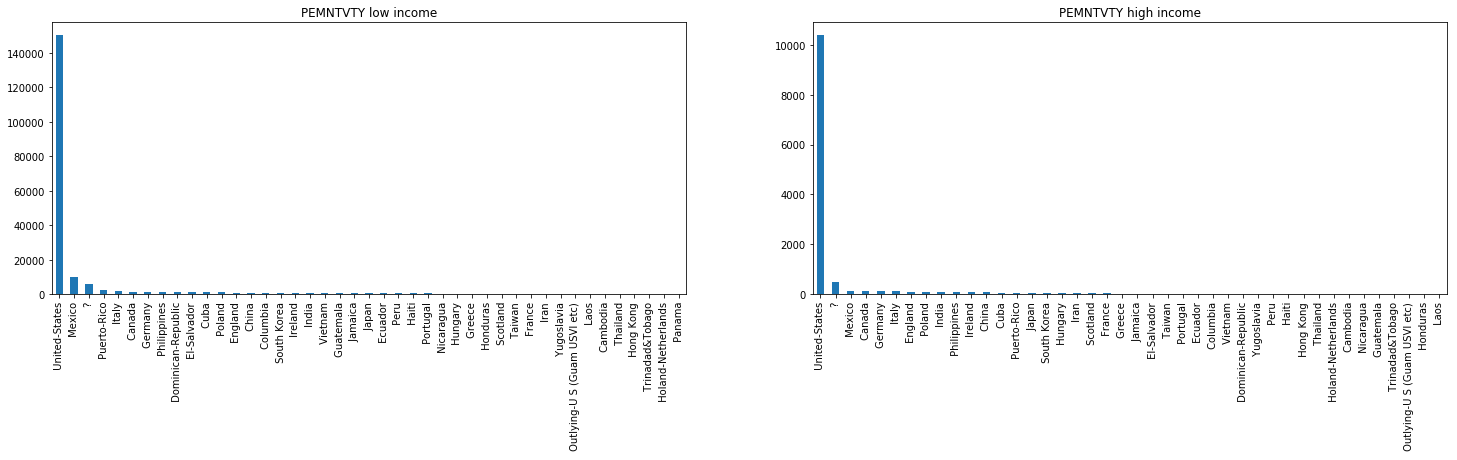

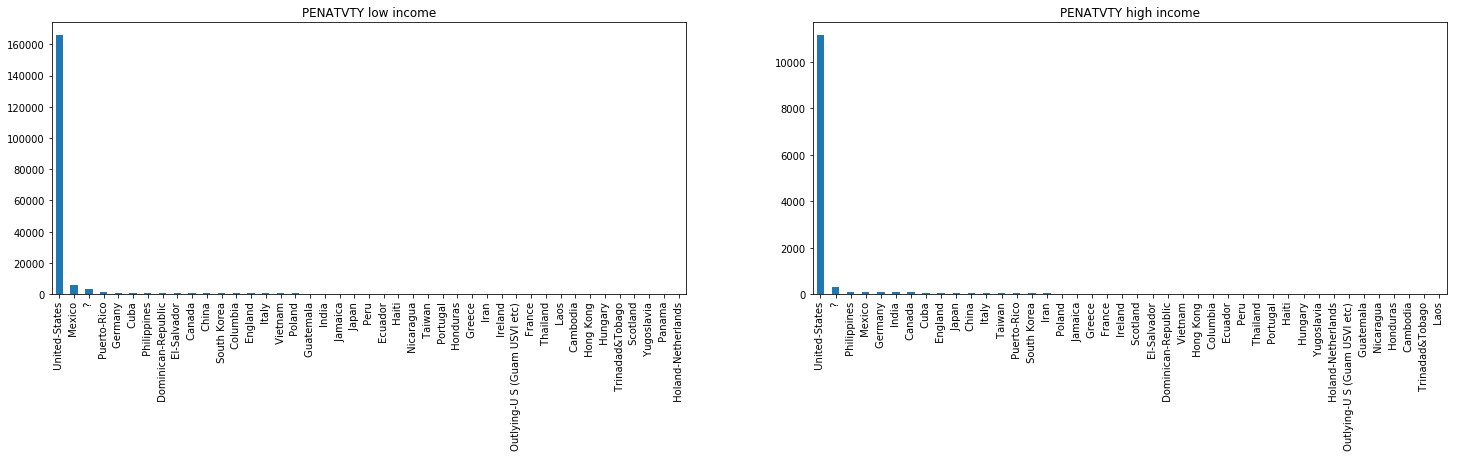

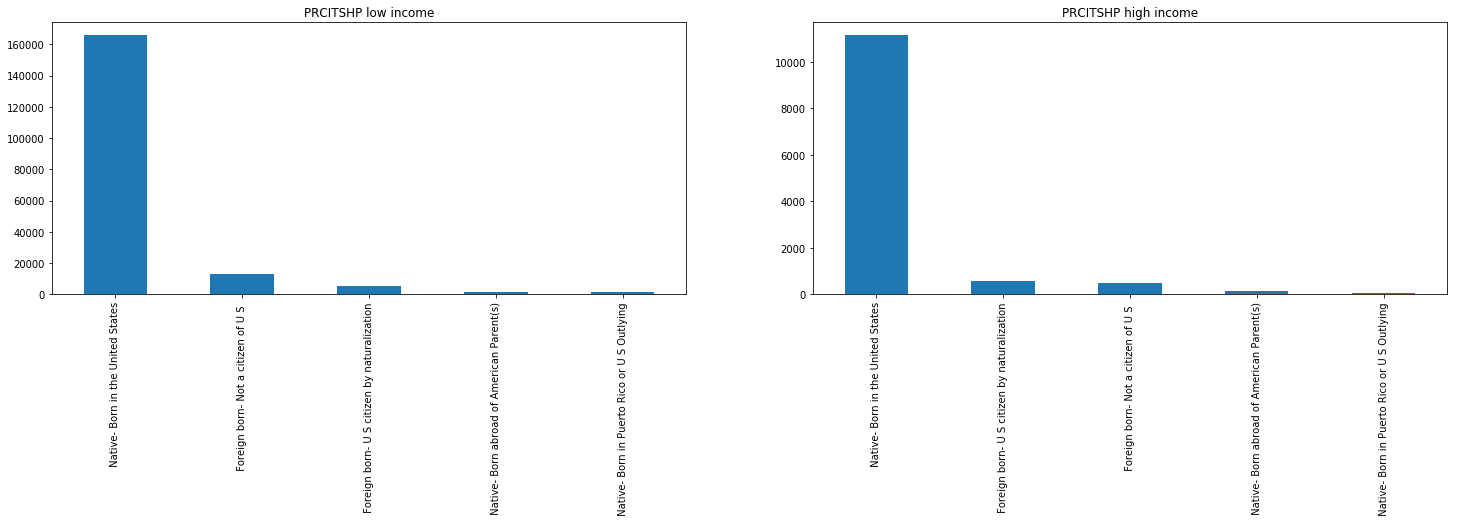

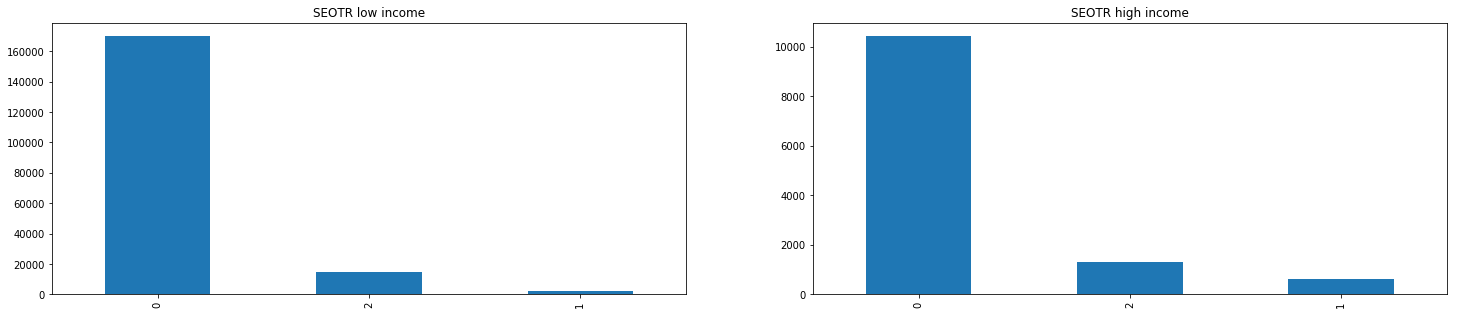

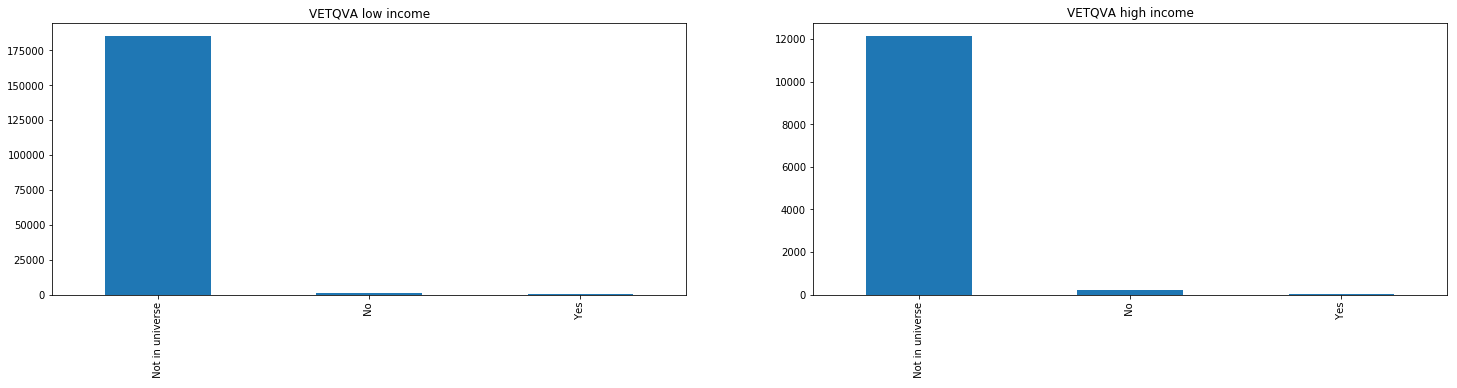

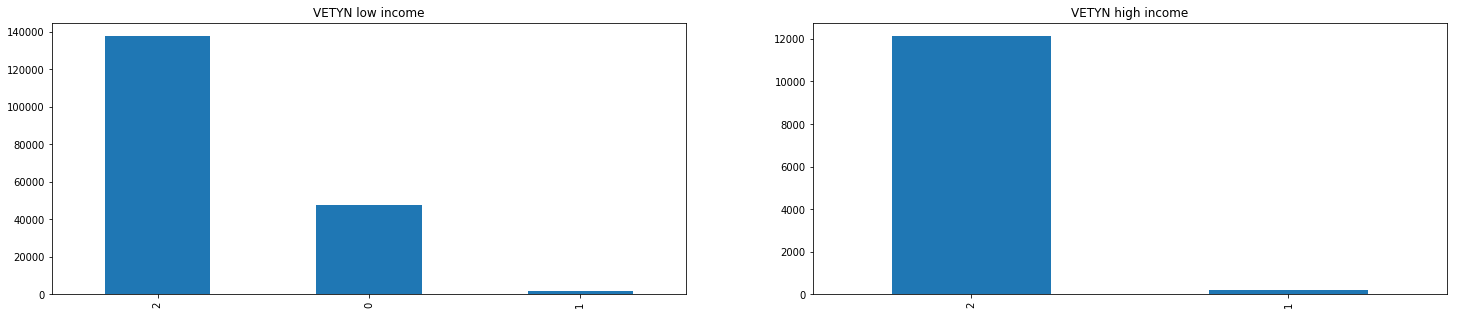

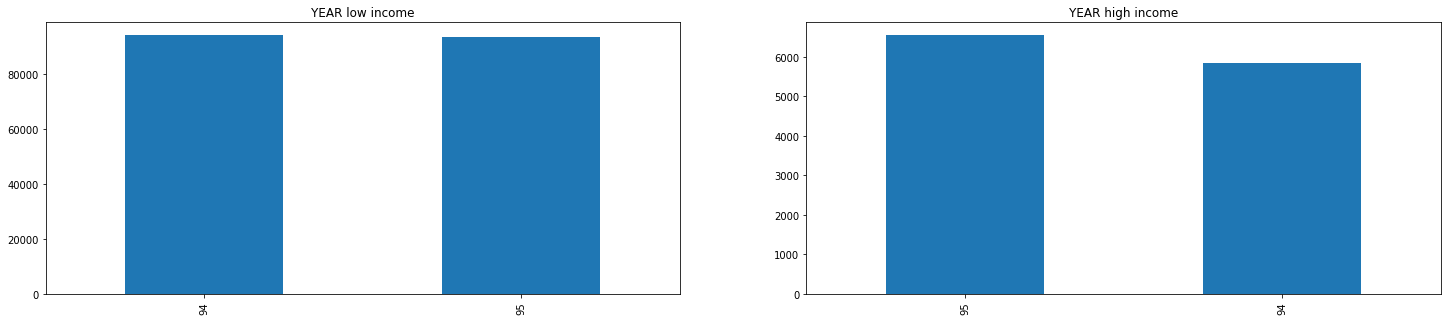

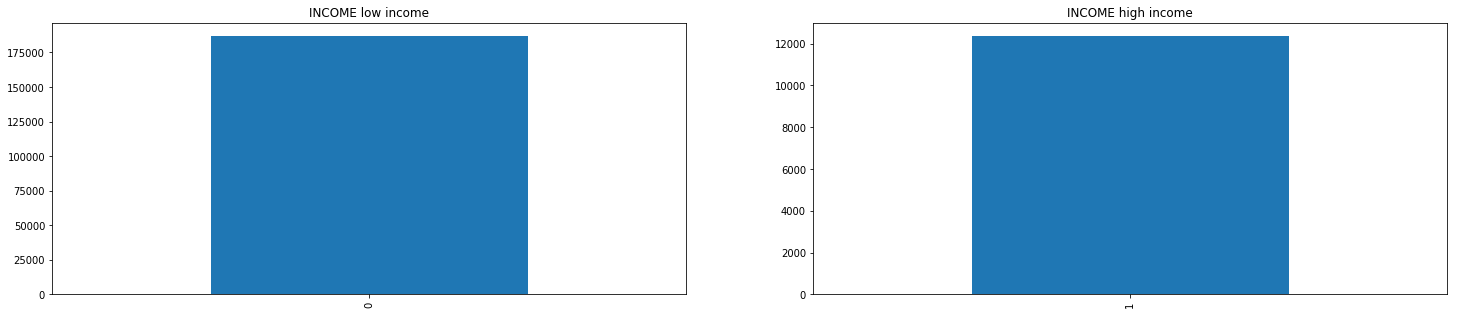

In [42]:
# Annexe all the plots of the data
for k in categorical:
    fig,axes=plt.subplots(nrows=1,ncols=2)
    df[k].loc[(df["INCOME"]==1) ].value_counts().plot(kind="bar",title=(k+' high income'),ax=axes[1],figsize=(25,5))
    df[k].loc[(df["INCOME"]==0) ].value_counts().plot(kind="bar",title=(k+' low income'),ax=axes[0],figsize=(25,5))
    plt.show()